# 0a. Imports

In [1]:
from pathlib import Path
import importlib
import re
from datetime import datetime
from functools import partial

import dill
import numpy as np
import pandas as pd
import scipy as sci
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec

import gm
import gm.viz
from config import cfg, ROOT
from src.data import get_rgi
from src.flowline import get_flowline_geom

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 0b. Define some plot functions

In [24]:
mb = pd.read_csv(Path(ROOT, 'data/external/mb/hintereisferner/HEF_elevation_zones.csv'))
ela = pd.read_csv(Path(ROOT, 'data/external/mb/hintereisferner/HEF_mass_balance.csv'))

def plot_dbdz(res, hmb):
    if hmb:
        dbdz = np.gradient(res.b[-1, :]) / np.gradient((res.zb + res.h[-1, :]))
    else:
        dbdz = np.gradient(res.b[-1, :]) / np.gradient((res.zb))
    obs_dbdz = mb.groupby('yr1').apply(lambda mb: (mb['b'] / 1000).diff(-1) / mb['z0'].diff(-1))
    obs_dbdz = pd.DataFrame(obs_dbdz.reset_index(level=1, drop=True).reset_index())
    obs_dbdz.columns = ['yr', 'dbdz']
    obs_dbdz['z'] = mb['z0']
    ela_avg = ela.copy().mean(axis=0)
    
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), dpi=200, layout='constrained')
    for year, group in mb.groupby('yr1'):
        ax[0].plot(group.b / 1000, group.z0, color='black', alpha=0.25, lw=0.5)
    mb_avg = mb.groupby('z0').mean().reset_index()
    ax[0].plot(mb_avg.b / 1000, mb_avg.z0, color='black', lw=3)
    ax[0].axhline(ela_avg.ela, c='grey', label=f'Obs. balance profile (mean ELA = {ela_avg.ela:.0f}m)')
    ax[0].axvline(0, c='black')
    
    slope = np.arange(0.001, 0.015, 0.001)
    x = np.arange(-5, 2, 0.1)
    x0 = res.b[-1, res.edge_idx[-1] - 1]
    if hmb:
        y0 = res.zb[res.edge_idx[-1] - 1] + res.h[-1, res.edge_idx[-1] - 1]
    else:
        y0 = res.zb[res.edge_idx[-1] - 1]
    X, M = np.meshgrid(x, slope)
    Y = (X - x0) * 1 / M + y0
    contour = ax[0].contour(X, Y, M, colors='grey', linestyles='dashed', levels=len(slope) // 2)
    ax[0].clabel(contour, fontsize='small')
    
    if hmb:
        ax[0].plot(res.b[-1, :], res.zb + res.h[-1, :], color='red', lw=3)
    else:
        ax[0].plot(res.b[-1, :], res.zb, color='red', lw=3)
    
    # ax.fill_between(res.b[0, :], res.zb + res.h[0, :] + res.w/2, res.zb + res.h[0, :] - res.w/2, color='grey', alpha=0.25)
    ax[0].axhline(res.ela[-1], c='red', label=f'res balance profile (ELA = {res.ela[-1]:.0f}m)')
    
    # ax[0].axline((res.b[-1, res.edge_idx[0]], res.zb[res.edge_idx[0]] + res.h[-1, res.edge_idx[0]]), slope=slope, color='grey', ls='--')
    ax[0].set_ylim(res.zb[res.edge_idx[-1]], res.zb[0] + res.h[-1, 0])
    
    for year, group in obs_dbdz.groupby('yr'):
        ax[1].plot(group.z, group.dbdz, color='black', alpha=0.25, lw=0.5)
    obs_dbdz_mean = obs_dbdz.groupby('z').mean().reset_index()
    ax[1].plot(obs_dbdz_mean.z, obs_dbdz_mean.dbdz, color='black', lw=3, label='Obs. dbdz')
    if hmb:
        ax[1].plot(res.zb + res.h[-1, :], dbdz, color='red', lw=3, label='res dbdz')
    else:
        ax[1].plot(res.zb, dbdz, color='red', lw=3, label='res dbdz')
    
    for axis in ax.ravel():
        axis.grid(which='both', axis='both', ls=':')
        axis.legend()
    return fig, ax

# 0c. Load geometry

C:\sandbox\glacier-attribution\src\flowline.py:52: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  fl, inv, dsl = pickle.load(openfile)
C:\sandbox\glacier-attribution\src\flowline.py:56: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mfl = pickle.load(openfile)
C:\sandbox\glacier-attribution\src\flowline.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\sandbox\glacier-attribution\src\flowline.py:189: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


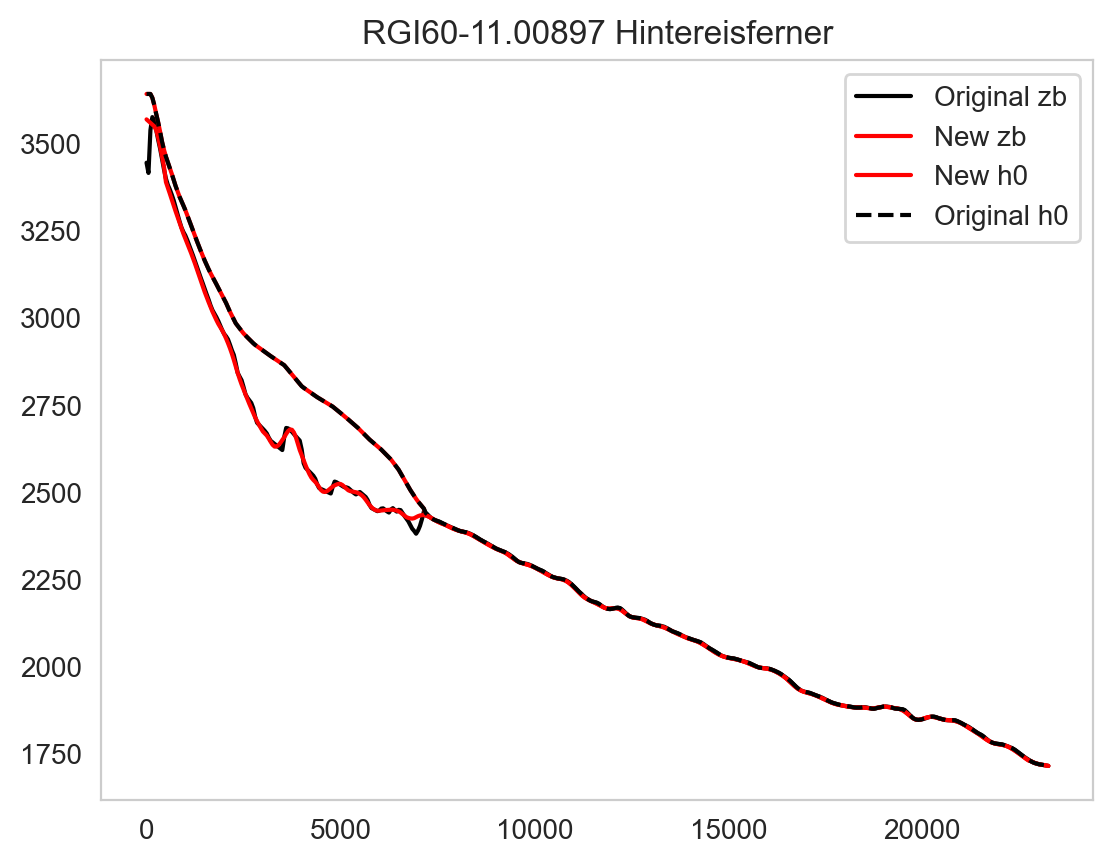

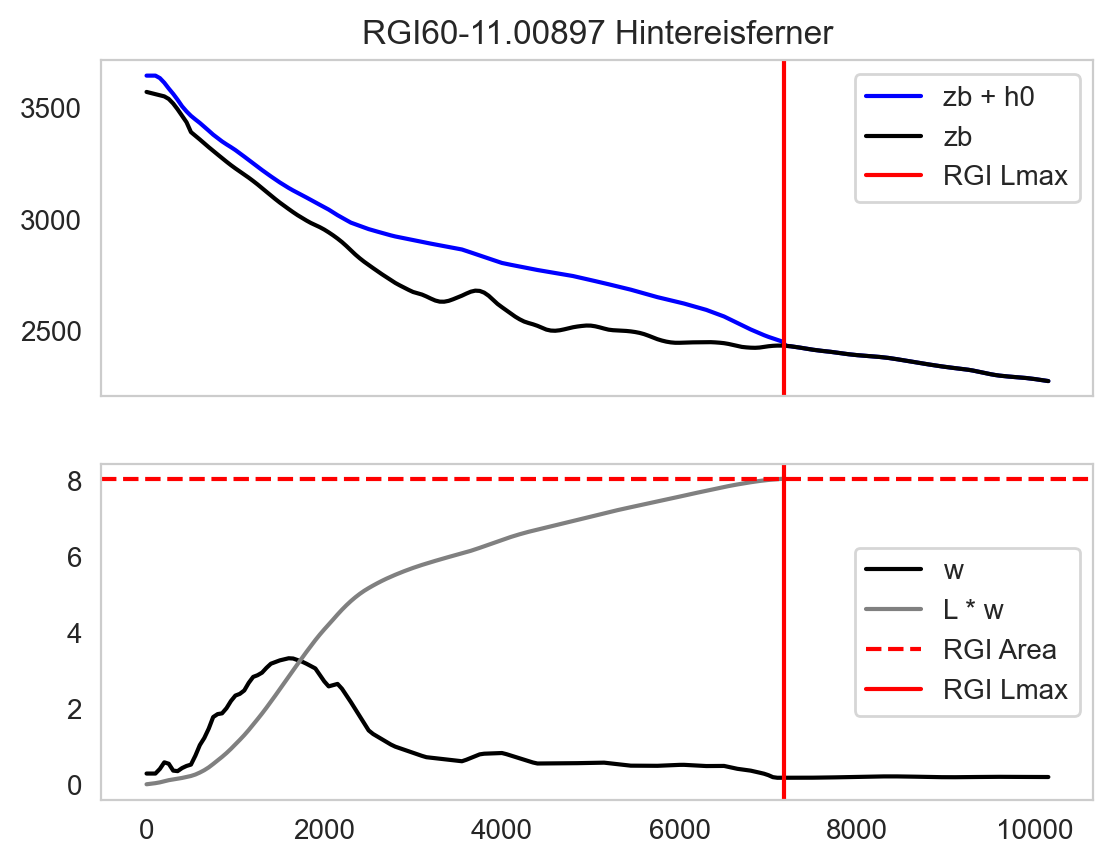

In [3]:
glacier = 'Hintereisferner'
rgiid = list({k: v for k, v in cfg['glaciers'].items() if v['name'] == glacier}.keys())[0]
rgi = get_rgi(rgiid, from_sqllite=True)
trgi = int(rgi.iloc[0]['BgnDate'][0:4])  # time rgi

geom = get_flowline_geom(rgiid)


In [4]:
import config

importlib.reload(config)
importlib.reload(gm)
from config import cfg

params = cfg['glaciers'][rgiid]['flowline_params']

# 0c. Create climate noise

In [5]:
rng = np.random.default_rng(12345)
nruns = 20
t0 = 0
t1 = 4000
t = np.arange(t0, t1, 1)
Tnoise = []
Pnoise = []

for n in range(nruns):
    T = pd.Series(rng.standard_normal(len(t)), index=t)
    P = pd.Series(rng.standard_normal(len(t)), index=t)
    Tnoise.append(T)
    Pnoise.append(P)

# double step change
temp = pd.Series(np.concatenate(
    [np.full(t1 // 4, fill_value=0), np.full(t1 // 4, fill_value=0.25), np.full(t1 // 4, fill_value=0),
     np.full(t1 // 4, fill_value=-0.25)]))

# 1a. Calibrating a new profiles
With reasonable mu and crazy gamma (everyone has that one crazy gamma!)
Setting L = 9km to be approximately 850 length.

In [6]:
gm.calc_ela(P0=0.5, T0=38.34, gamma=13.5e-3, mu=0.8)

2793.7037037037044

100%|######################################################| 2000.0/2000.0 [00:14<00:00, 141.09yrs/s


9000.0
hmb feedback = True


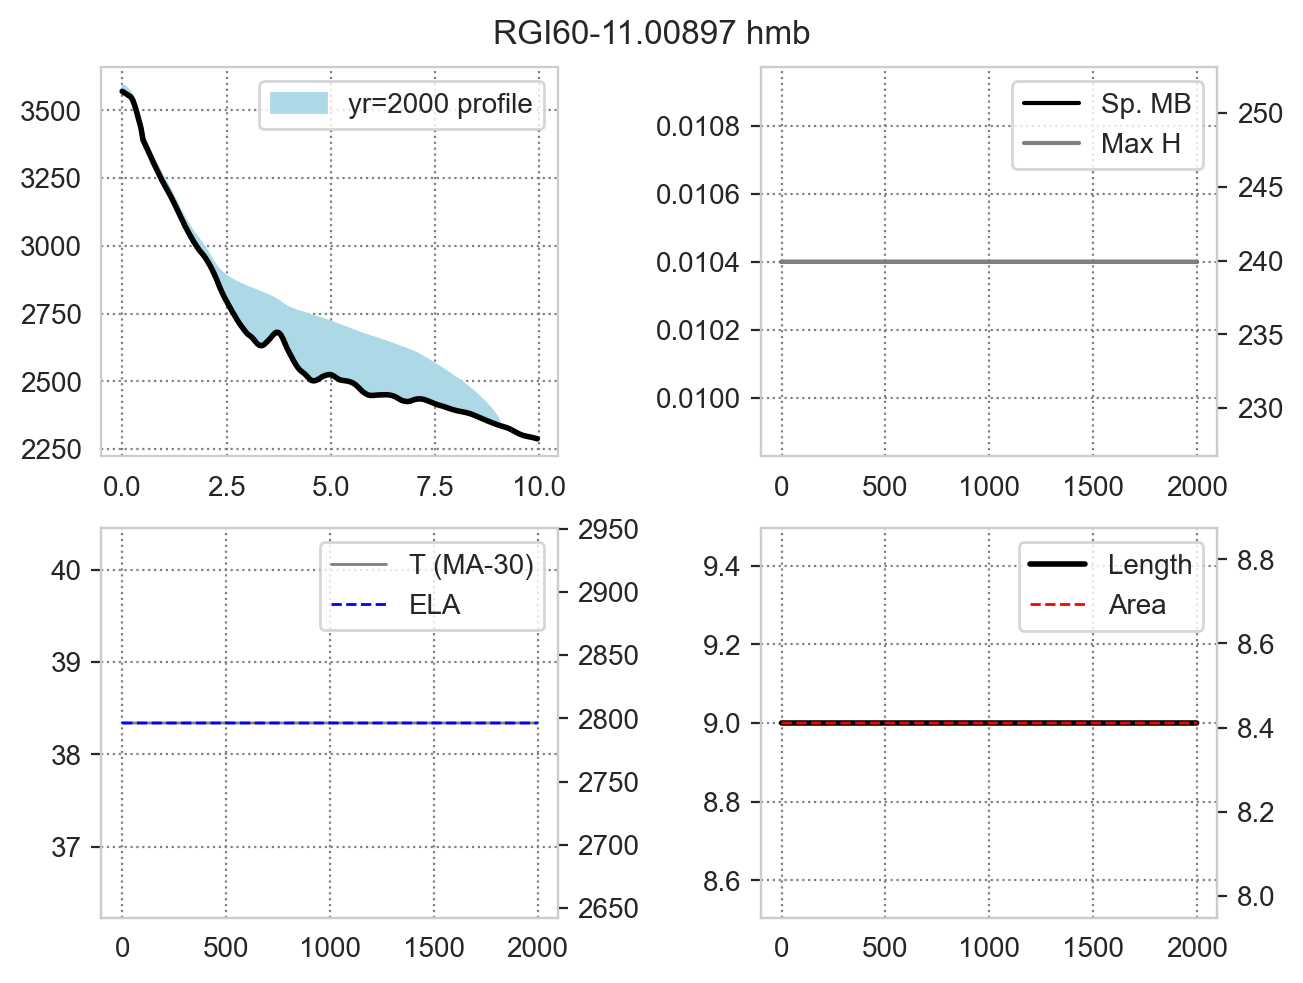

In [7]:
exp_name = 'hmb'
variant = 'on'
t0 = 0
t1 = 2000
ref0 = 0
ref1 = 100

T = np.zeros(t1)
P = np.zeros(t1)

fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
#fp = Path(ROOT, f'flowline2d_{rgiid}.profile.850.pickle')
model = gm.flowline2d(
    x_gr=geom.x,
    zb_gr=geom.zb,
    x_geom=geom.x,
    w_geom=geom.w,
    profile=fp,
    xmx=geom.x.max(),
    sigT=params['sigT'],
    sigP=params['sigP'],
    delt=0.0125 / 8,
    delx=50,
    ts=t0,
    tf=t1, 
    P0=0.5,
    T0=38.34,
    gamma=13.5e-3,
    mu=0.8,
    T=T,
    P=P,
    hmb=True,
)
model.ref_period = (ref0, ref1)
hmb = model.run()

fig, ax = hmb.plot()
fig.suptitle(f'{rgiid} {exp_name}')
fig_output_name = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.png')
fig.savefig(fig_output_name)

if hmb.no_error:
    fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
    hmb.to_pickle(fp)

print(hmb.edge[-1])
print(f"hmb feedback = {hmb.hmb}")

(<Figure size 1600x1600 with 2 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >], dtype=object))

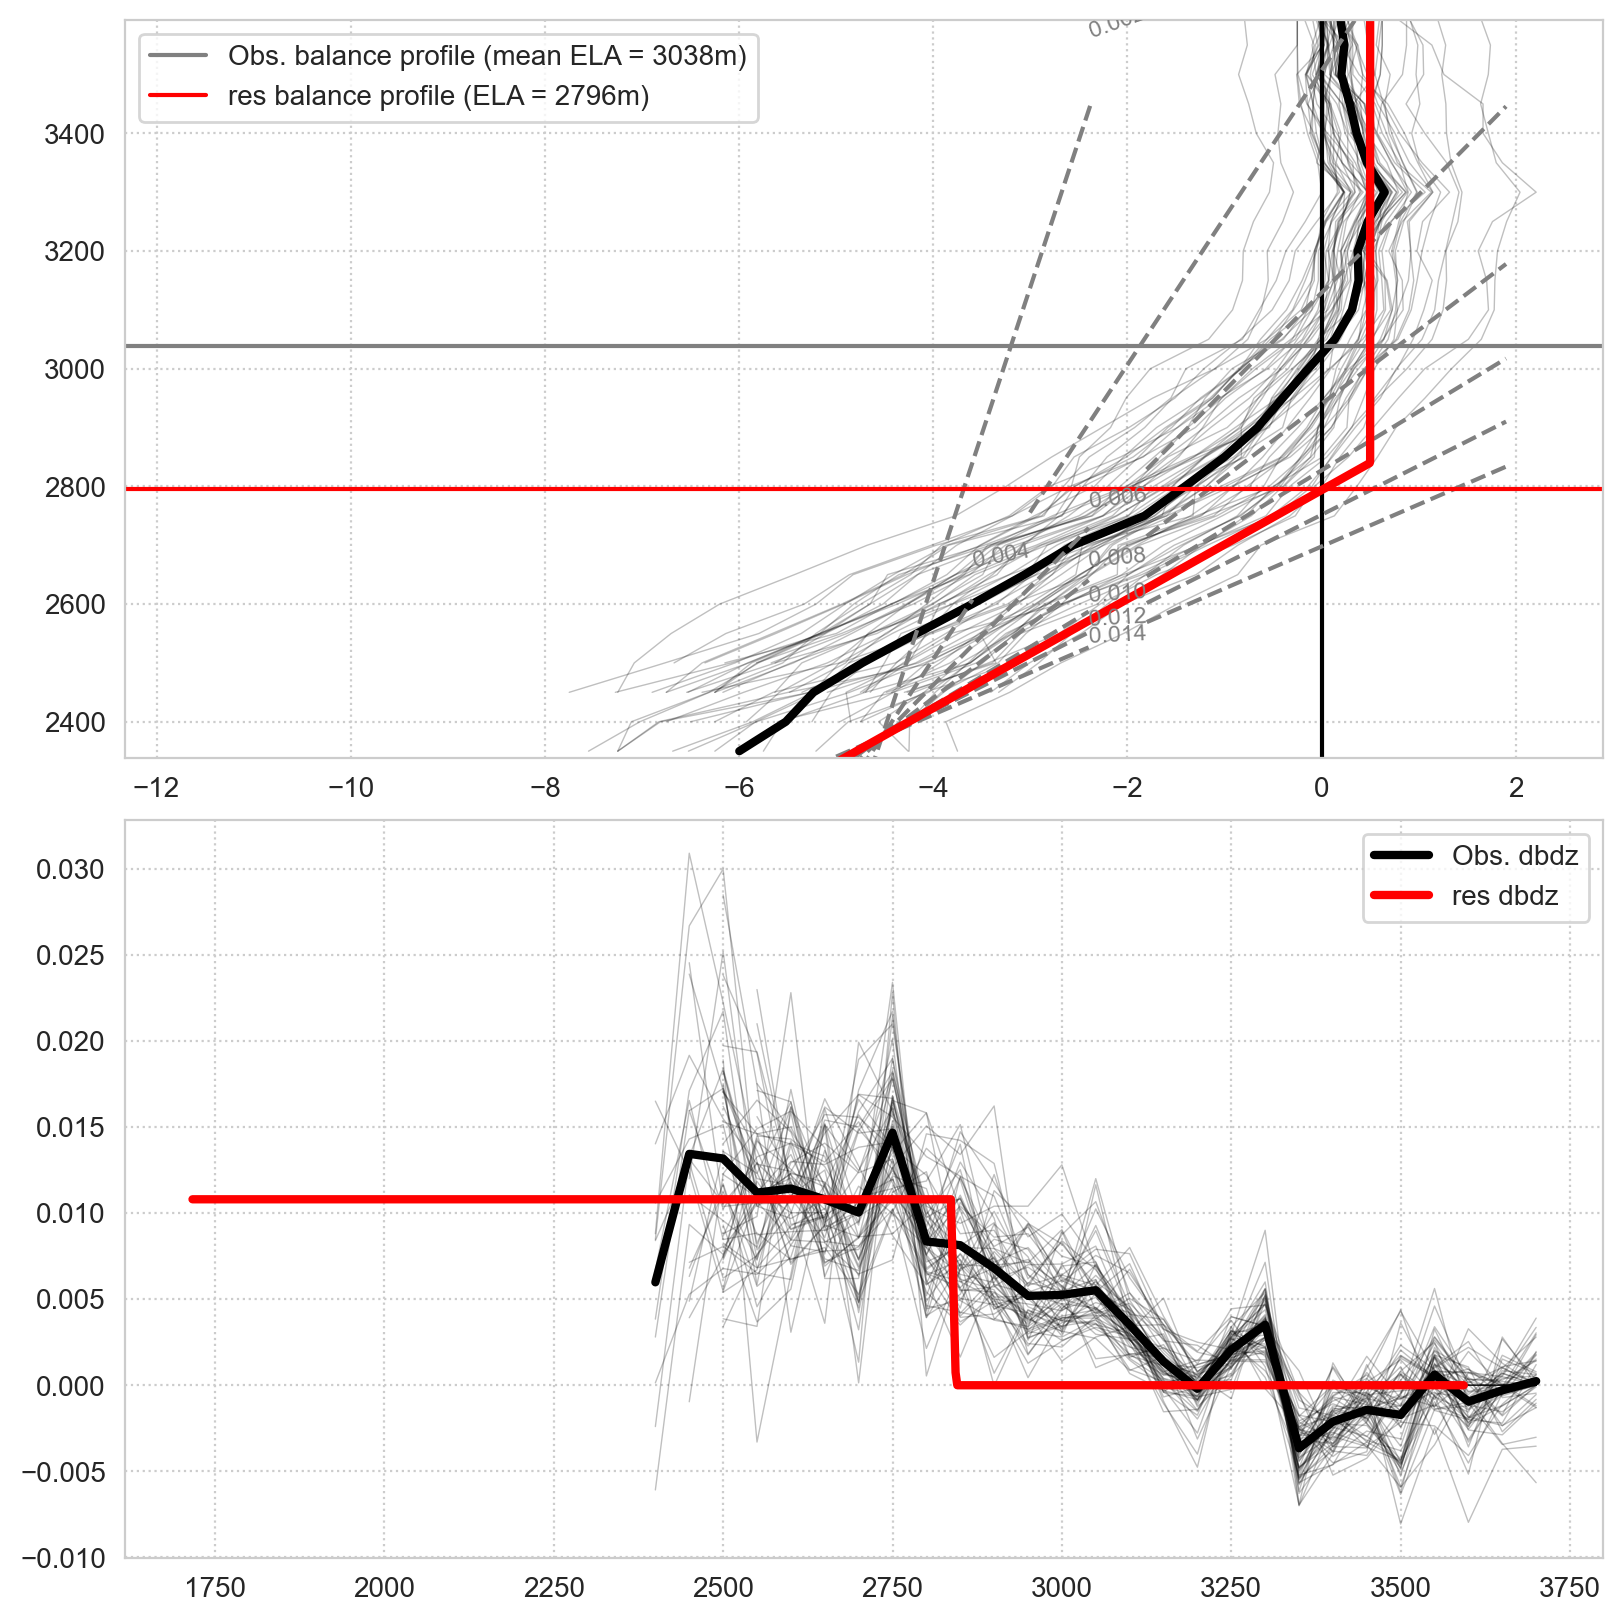

In [8]:
plot_dbdz(hmb, hmb=True)

# 1b. Without height-mass-balance feedback
Getting an equilibrium profile with the same length but without the HMB feedback results in a much lower bt. However, the observed response time is still faster in this case.

100%|######################################################| 2000.0/2000.0 [00:12<00:00, 154.39yrs/s


8950.0
hmb feedback = False


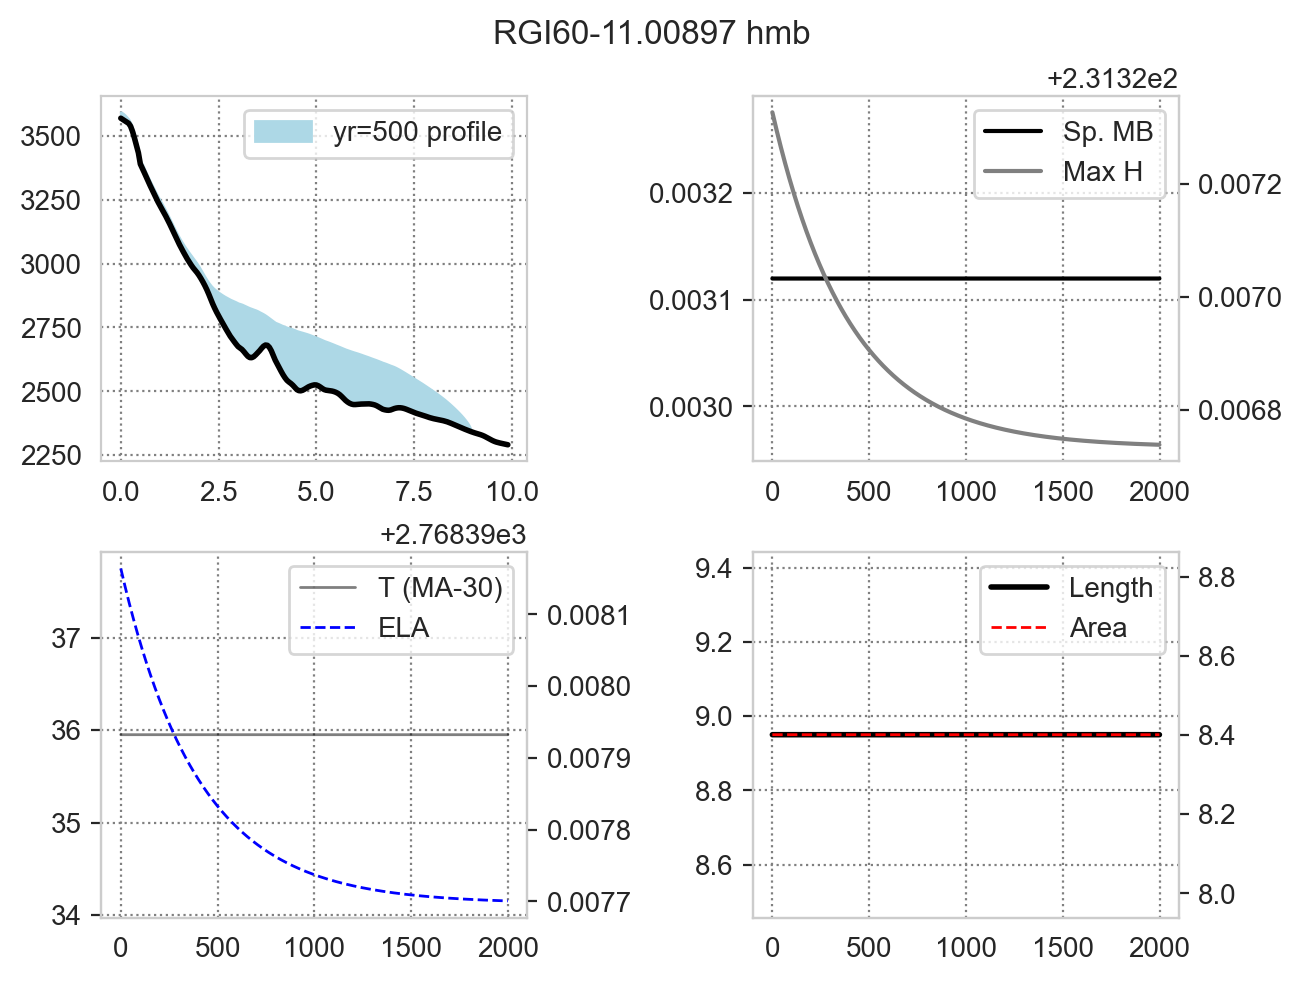

In [9]:
variant = 'off'
fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
#fp = Path(ROOT, f'flowline2d_{rgiid}.profile.850.pickle')
no_hmb = model.run(
    T0=35.95,
    hmb=False,
    profile=fp,
)
fig, ax = no_hmb.plot()
fig.suptitle(f'{rgiid} {exp_name}')
fig_output_name = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.png')
fig.savefig(fig_output_name)

if no_hmb.no_error:
    fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
    no_hmb.to_pickle(fp)


print(no_hmb.edge[-1])
print(f"hmb feedback = {no_hmb.hmb}")

(<Figure size 1600x1600 with 2 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >], dtype=object))

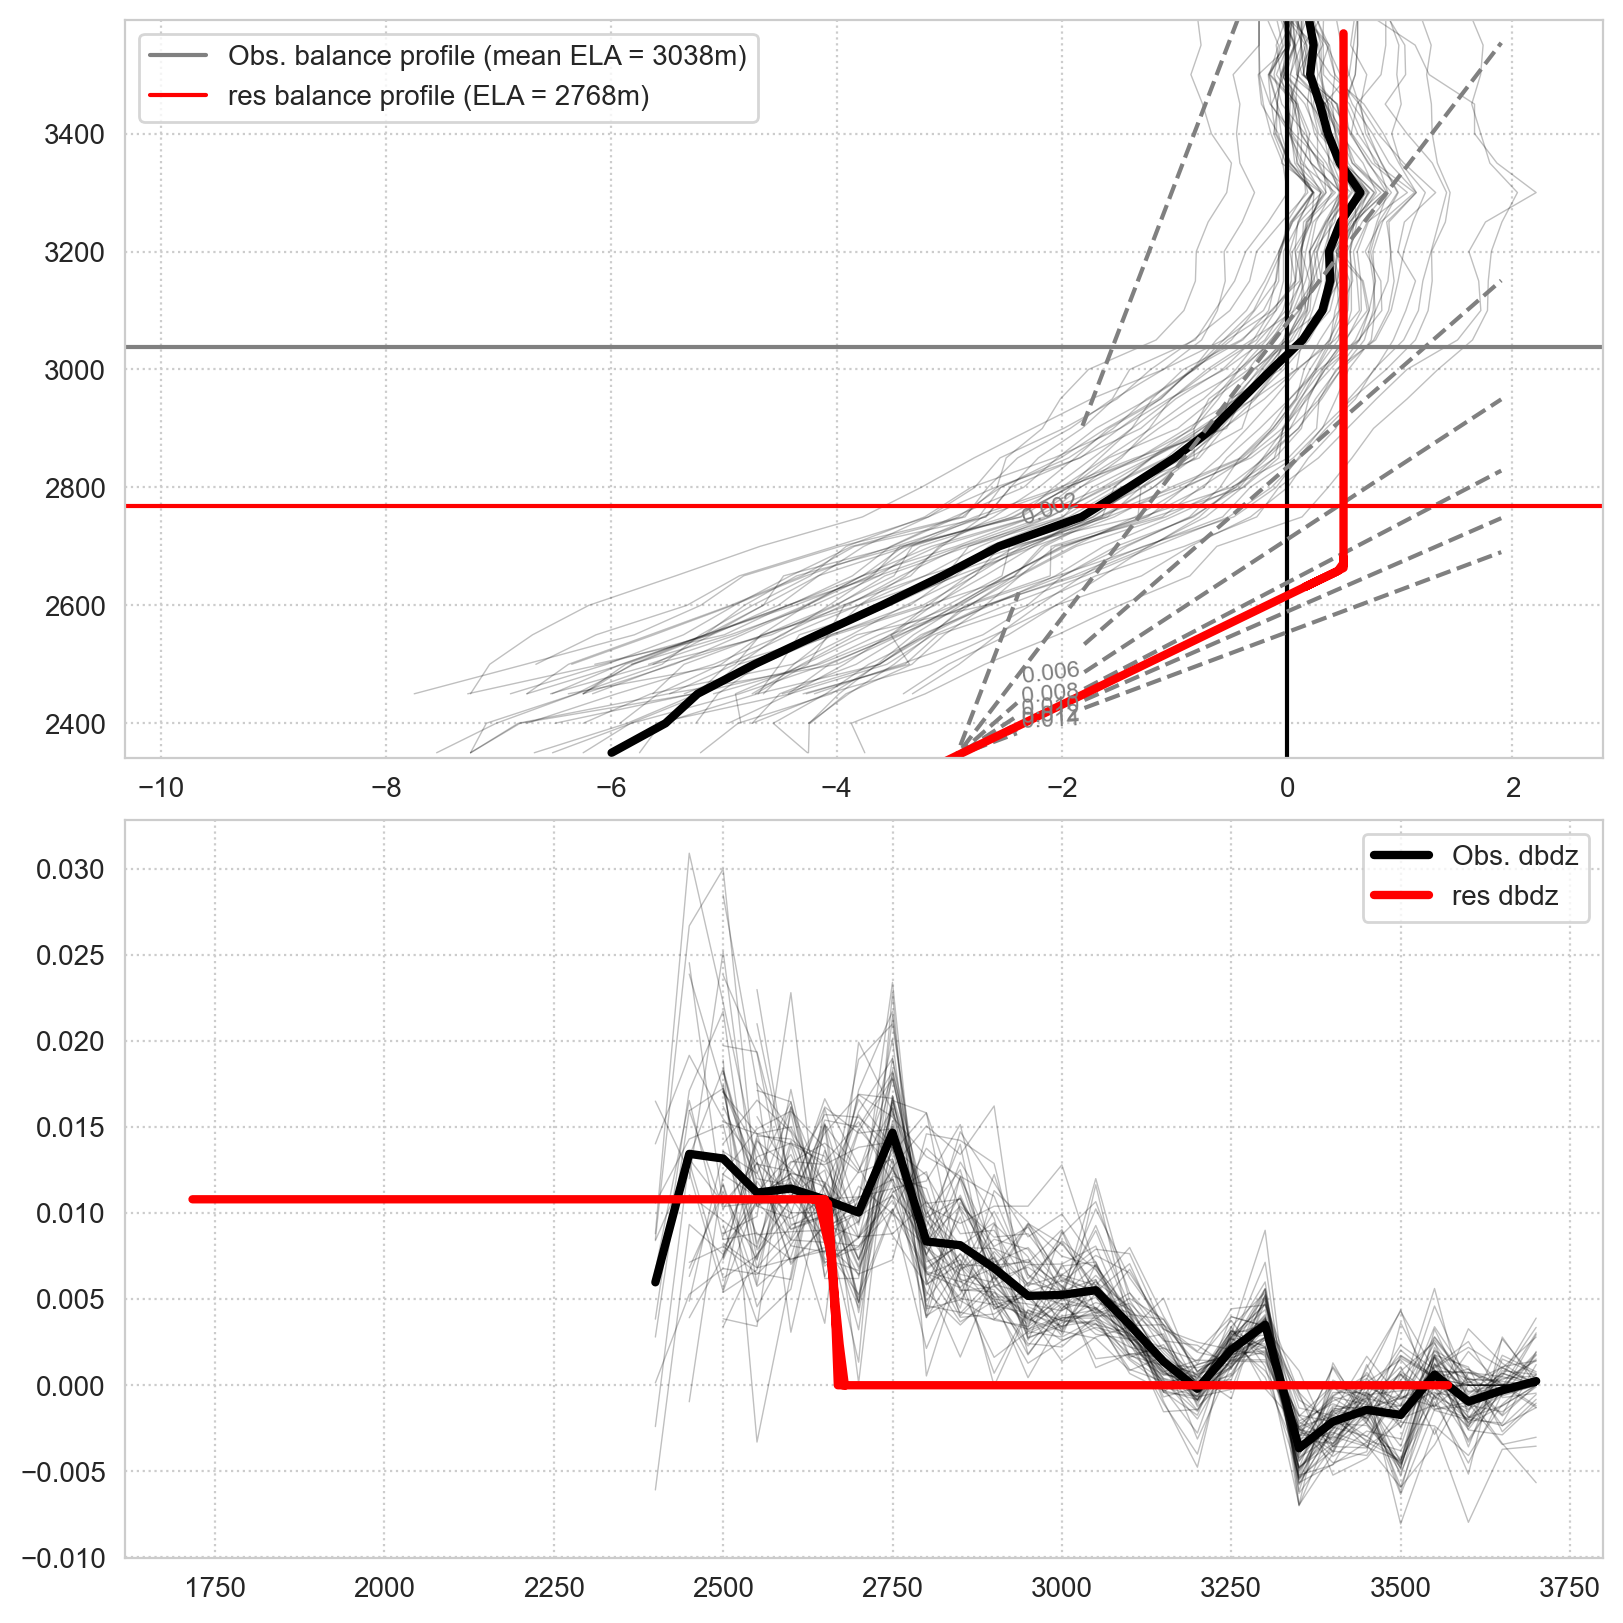

In [10]:
plot_dbdz(no_hmb, hmb=False)

# 2a. Step changes
Previously, the HMB glacier had 2 equilibria for the same temperature depending on path. Does this still happen & is it resilient to noise perturbations?
Yes it does. Is the behavior of the HMB glacier realistic? 

In [14]:
t0 = 0
t1 = 4000
temp = pd.Series(np.concatenate(
    [np.full(t1 // 4, fill_value=0), np.full(t1 // 4, fill_value=0.1), np.full(t1 // 4, fill_value=0),
     np.full(t1 // 4, fill_value=-0.1)]))
model = gm.flowline2d(
    x_gr=geom.x,
    zb_gr=geom.zb,
    x_geom=geom.x,
    w_geom=geom.w,
    xmx=geom.x.max(),
    profile=fp,  # messy
    sigT=params['sigT'],
    sigP=params['sigP'],
    delt=0.0125 / 8,
    delx=50,
    ts=t0,
    tf=t1, 
    P0=0.5,
    T0=38.34,
    gamma=13.5e-3,
    mu=0.8,
    temp=temp,
    hmb=True,
)

100%|######################################################| 4000.0/4000.0 [00:26<00:00, 150.35yrs/s


(<Figure size 1280x960 with 7 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >]], dtype=object))

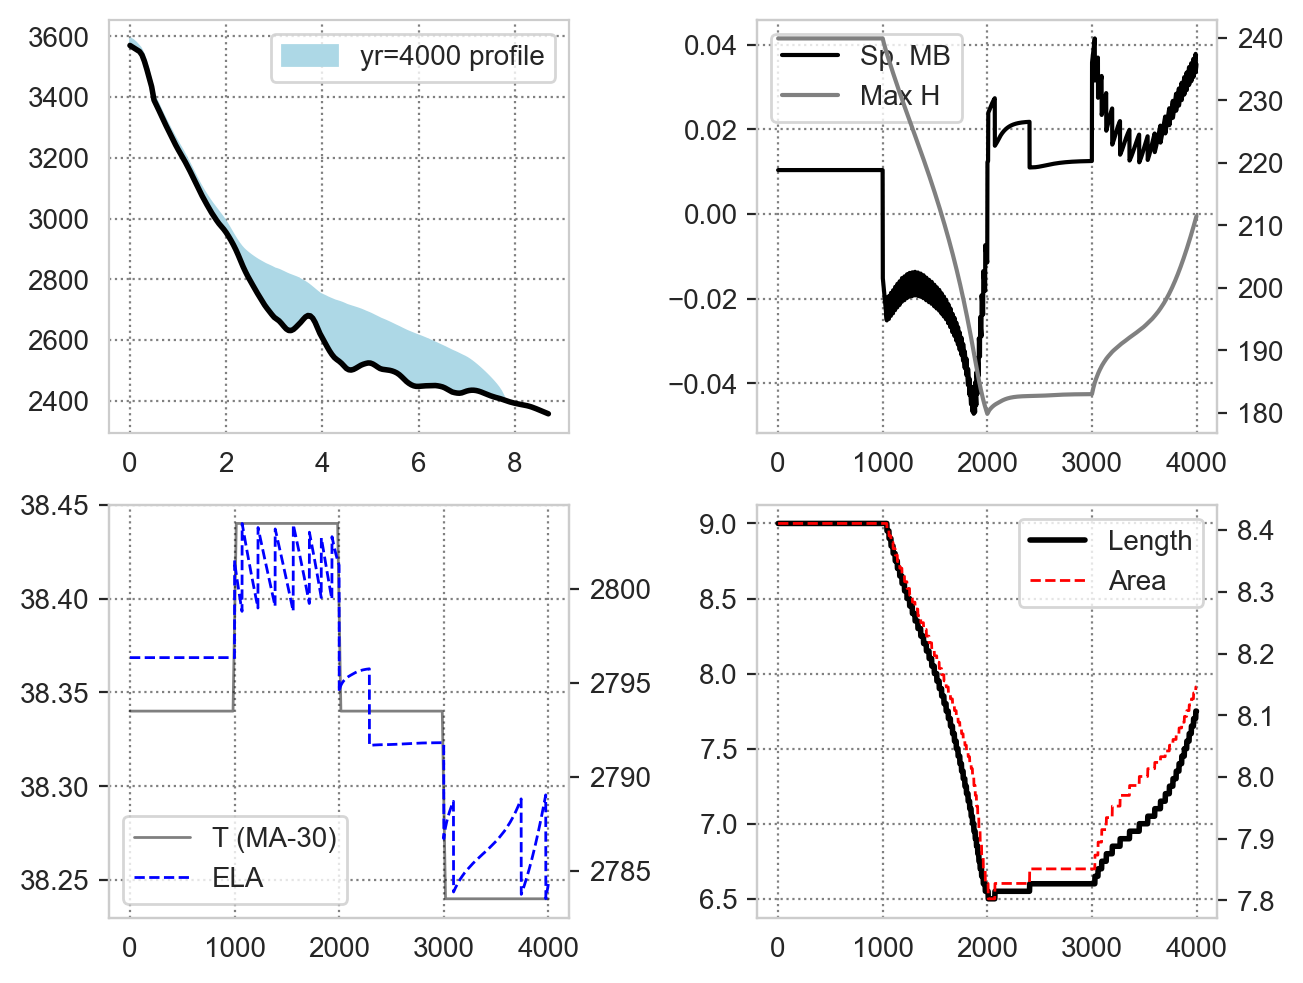

In [15]:
variant = 'on'
fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
hmb = model.run(profile=fp)
hmb.plot()

100%|######################################################| 4000.0/4000.0 [00:24<00:00, 166.12yrs/s


(<Figure size 1280x960 with 7 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >]], dtype=object))

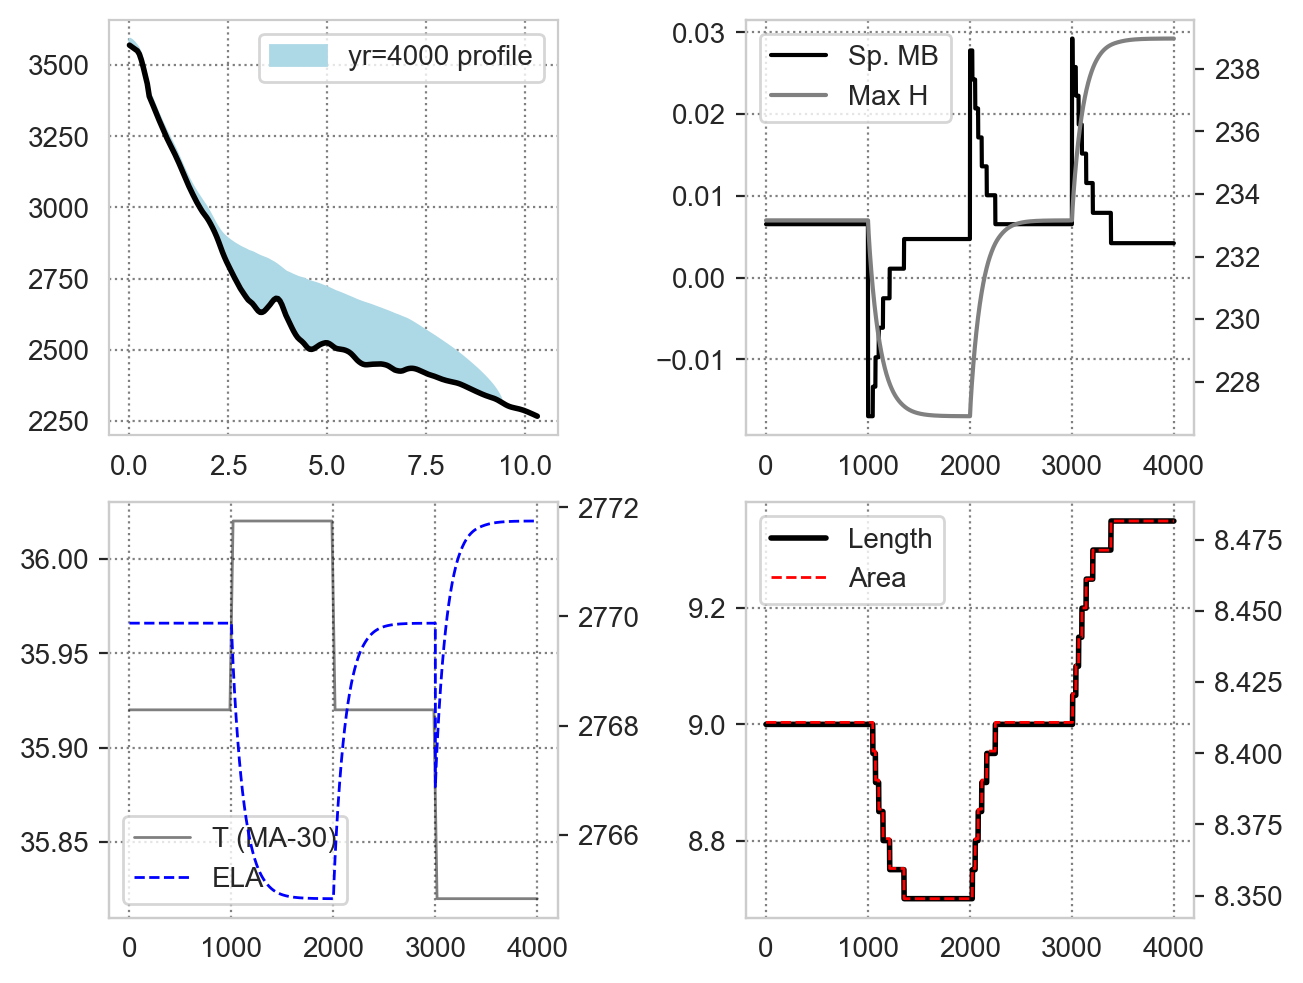

In [16]:
variant = 'off'
fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
no_hmb = model.run(profile=fp, hmb=False, T0=35.92)
no_hmb.plot()

Text(0.5, 0.98, 'Hintereisferner')

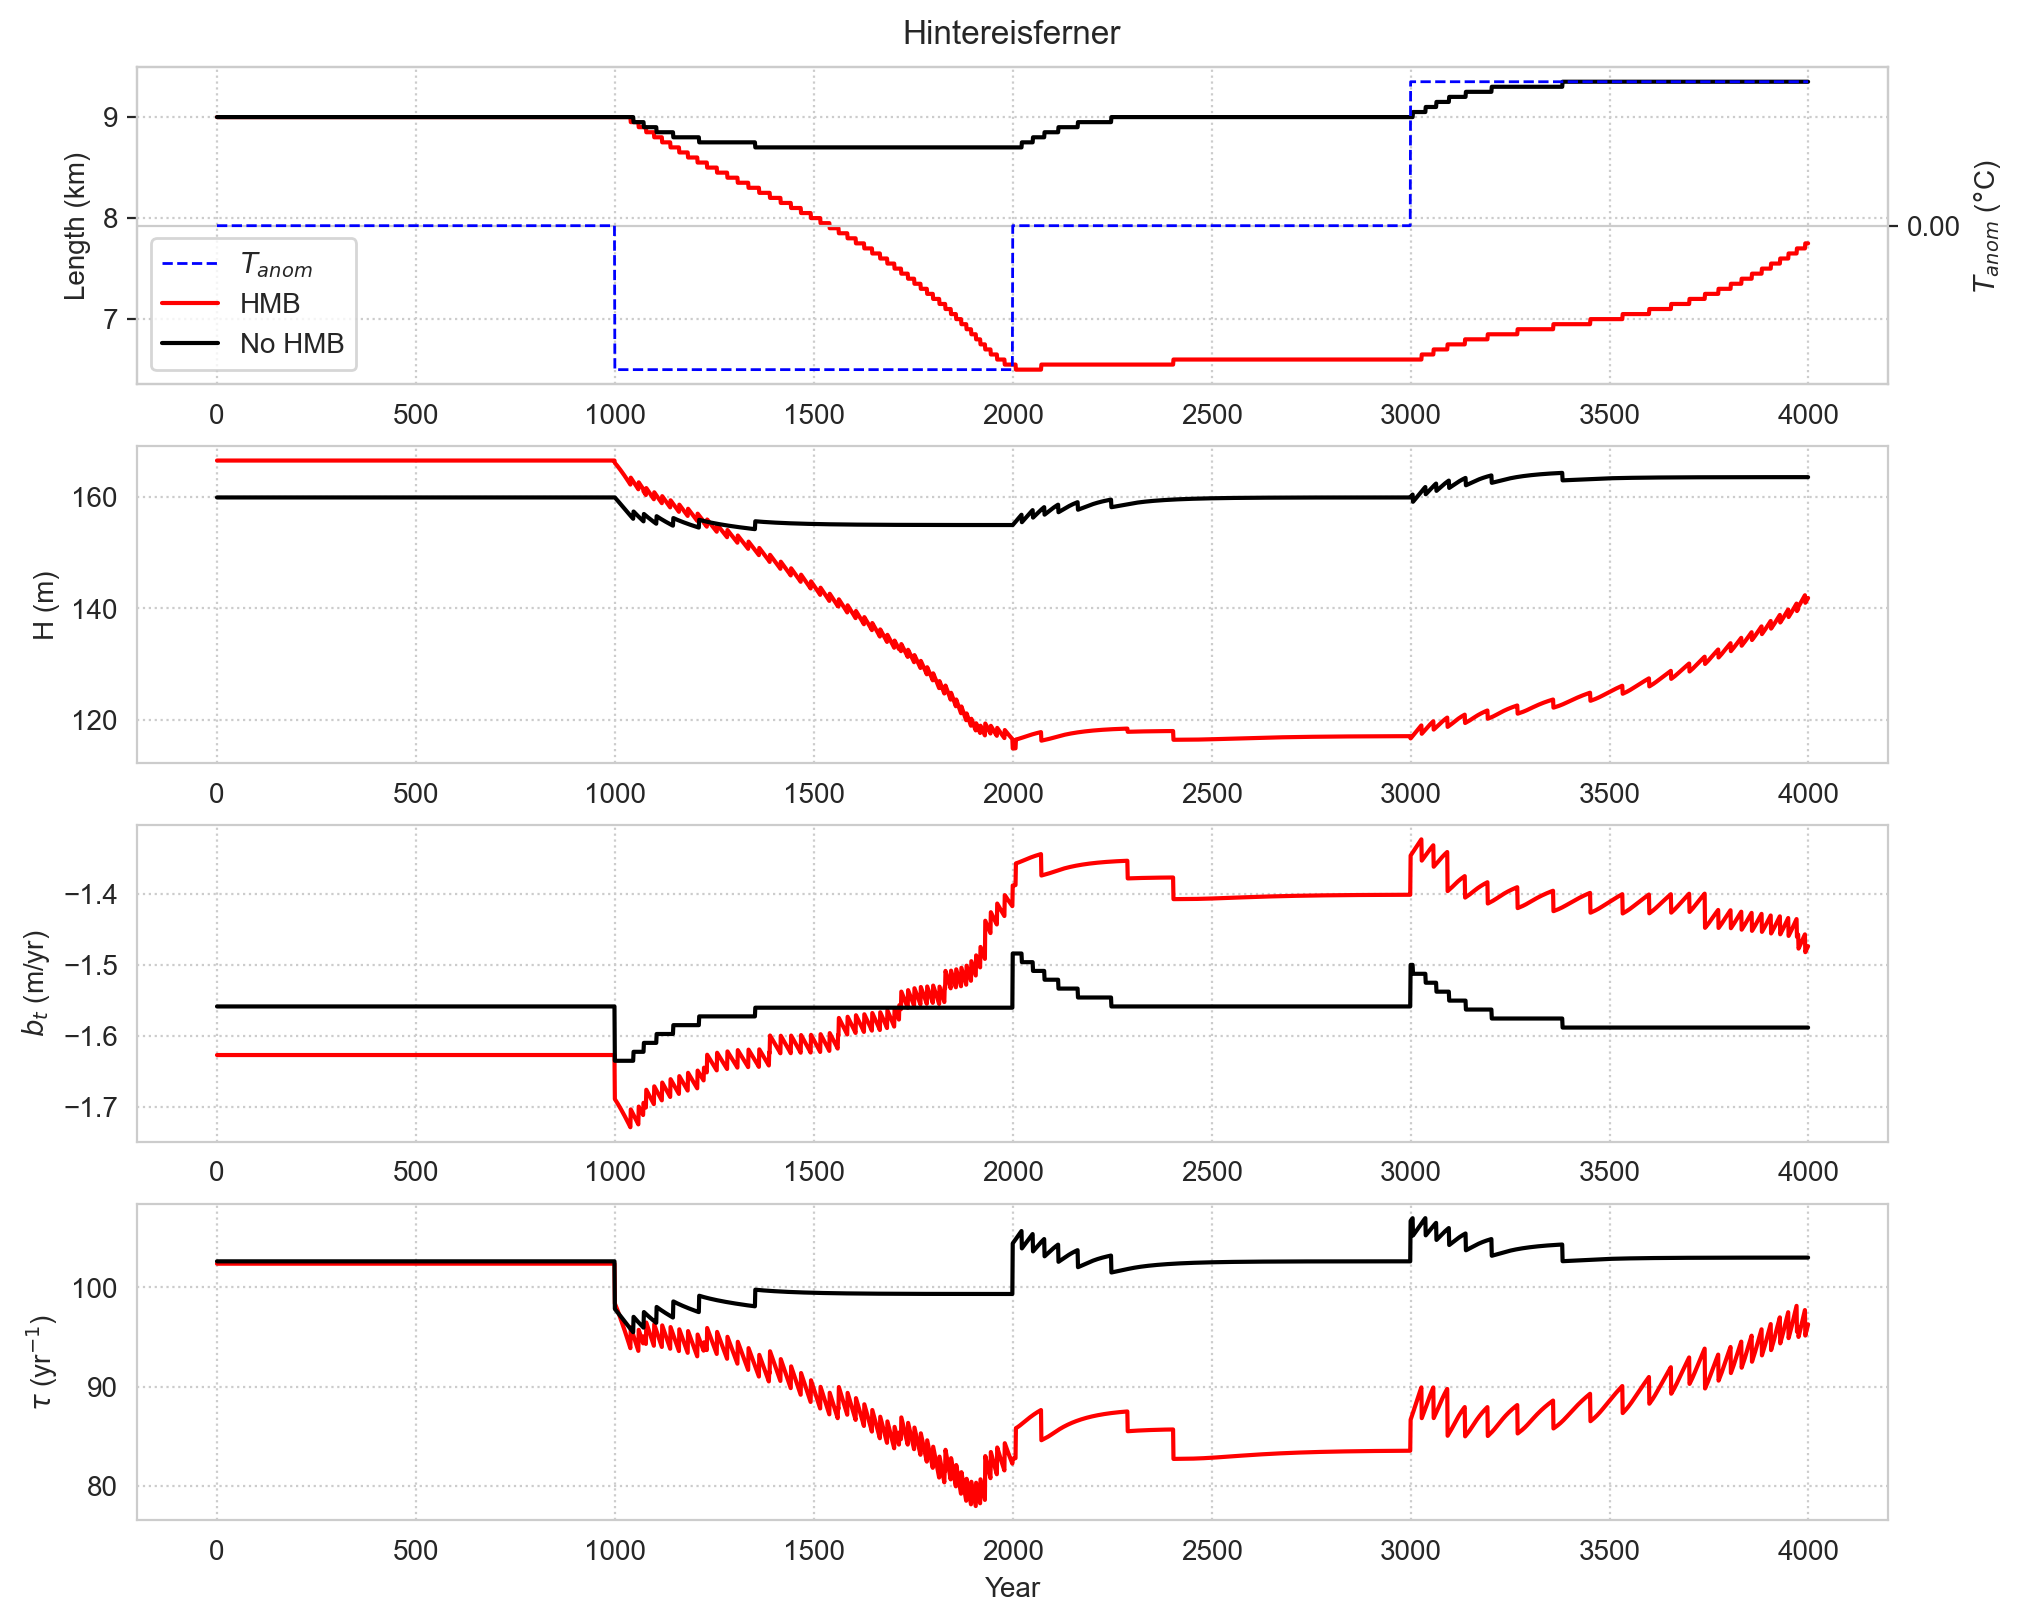

In [233]:

hmb_tau, hmb_H, hmb_bt = gm.calc_tau(hmb)
nhmb_tau, nhmb_H, nhmb_bt = gm.calc_tau(no_hmb)

fig, ax = plt.subplots(4, 1, figsize=(10, 8), dpi=200, layout='constrained')
ax[0].plot([None], [None], label='$T_{anom}$', c='blue', lw=1, ls='--')
ax[0].plot(hmb.t, hmb.edge / 1000, label='HMB', c='red')
ax[0].plot(no_hmb.t, no_hmb.edge / 1000, label='No HMB', c='black')
ax0b = ax[0].twinx()
ax0b.plot(hmb.t, -temp, label='$T_{anom}$', c='blue', lw=1, ls='--')
ax[1].plot(hmb.t, hmb_H, label='HMB H', c='red')
ax[1].plot(hmb.t, nhmb_H, label='No HMB H', c='black')
ax[2].plot(hmb.t, hmb_bt, label='HMB bt', c='red')
ax[2].plot(hmb.t, nhmb_bt, label='No HMB bt', c='black')
ax[3].plot(hmb.t, hmb_tau, label='HMB tau', c='red')
ax[3].plot(hmb.t, nhmb_tau, label='No HMB tau', c='black')

ax[0].legend()
ax[0].set_ylabel('Length (km)')
ax0b.set_ylabel('$T_{anom}$ ($\degree$C)')
ax0b.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
ax[1].set_ylabel('H (m)')
ax[2].set_ylabel('$b_t$ (m/yr)')
ax[3].set_ylabel(r'$\tau$ (yr$^{-1}$)')
ax[-1].set_xlabel('Year')
for axis in ax:
    axis.grid(which='both', axis='both', ls=':')
    
fig.suptitle('Hintereisferner')

# 2b. Repeat with noise
Do both HMB & no-HMB still have the same behavior?

In [17]:
t0 = 0
t1 = 4000
temp = pd.Series(np.concatenate(
    [np.full(t1 // 4, fill_value=0), np.full(t1 // 4, fill_value=0.1), np.full(t1 // 4, fill_value=0),
     np.full(t1 // 4, fill_value=-0.1)]))
model = gm.flowline2d(
    x_gr=geom.x,
    zb_gr=geom.zb,
    x_geom=geom.x,
    w_geom=geom.w,
    xmx=geom.x.max(),
    profile=fp,  # messy
    #sigT=0.1, # just a little wiggle
    sigT=0.25,  # wiggle = perturbation
    sigP=params['sigP'],
    delt=0.0125 / 8,
    delx=50,
    ts=t0,
    tf=t1, 
    P0=0.5,
    T0=38.34,
    gamma=13.5e-3,
    mu=0.8,
    temp=temp,
    T=Tnoise[0],
    hmb=True,
)


100%|######################################################| 4000.0/4000.0 [00:25<00:00, 156.85yrs/s


(<Figure size 1280x960 with 7 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >]], dtype=object))

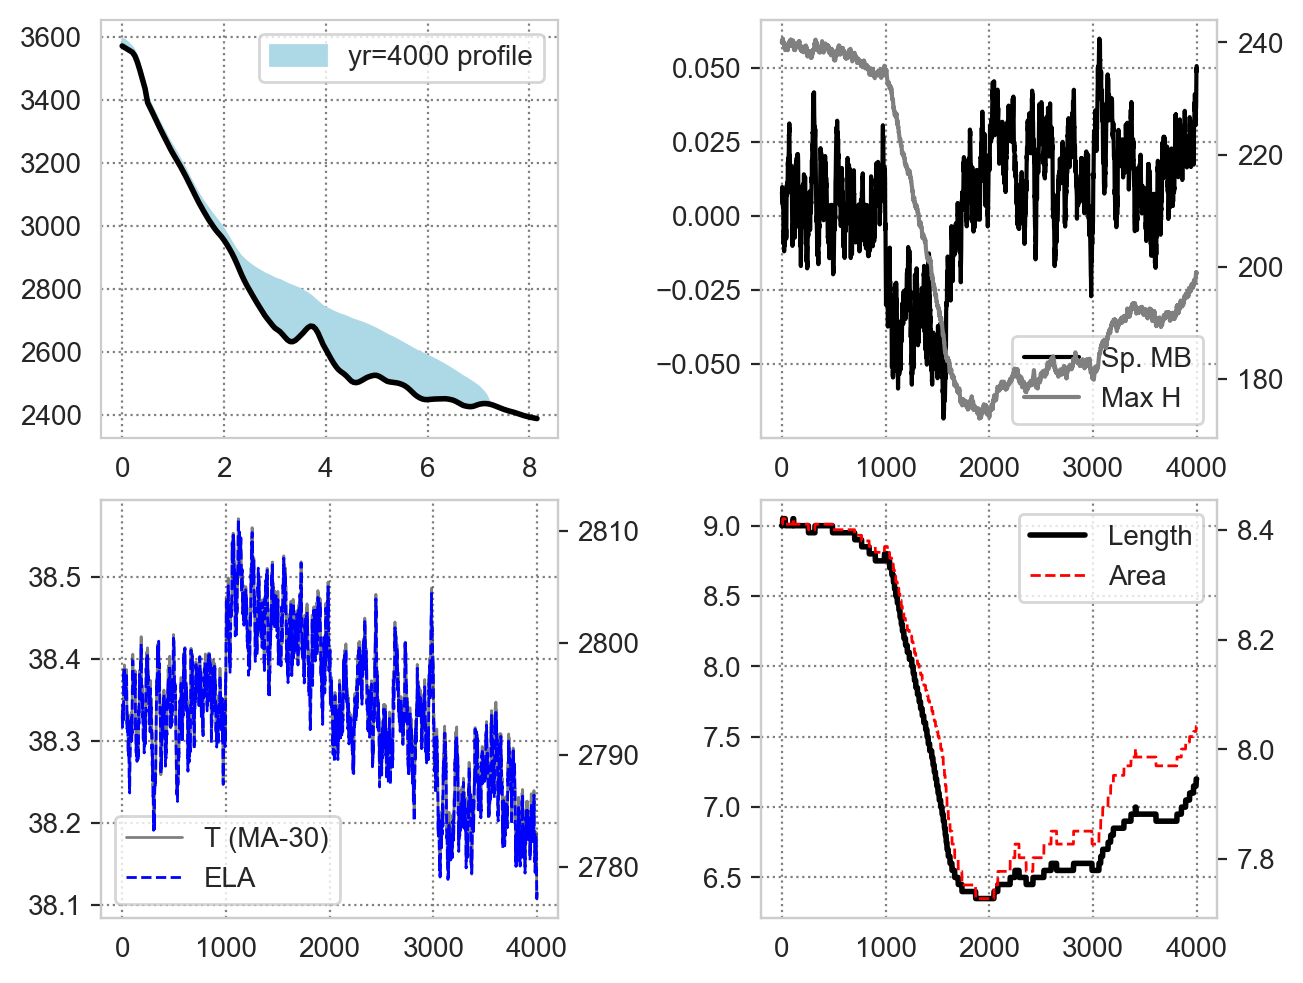

In [235]:
variant = 'on'
fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
hmb = model.run(profile=fp)
hmb.plot(smooth=30)


100%|######################################################| 4000.0/4000.0 [00:24<00:00, 160.94yrs/s


(<Figure size 1280x960 with 7 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >]], dtype=object))

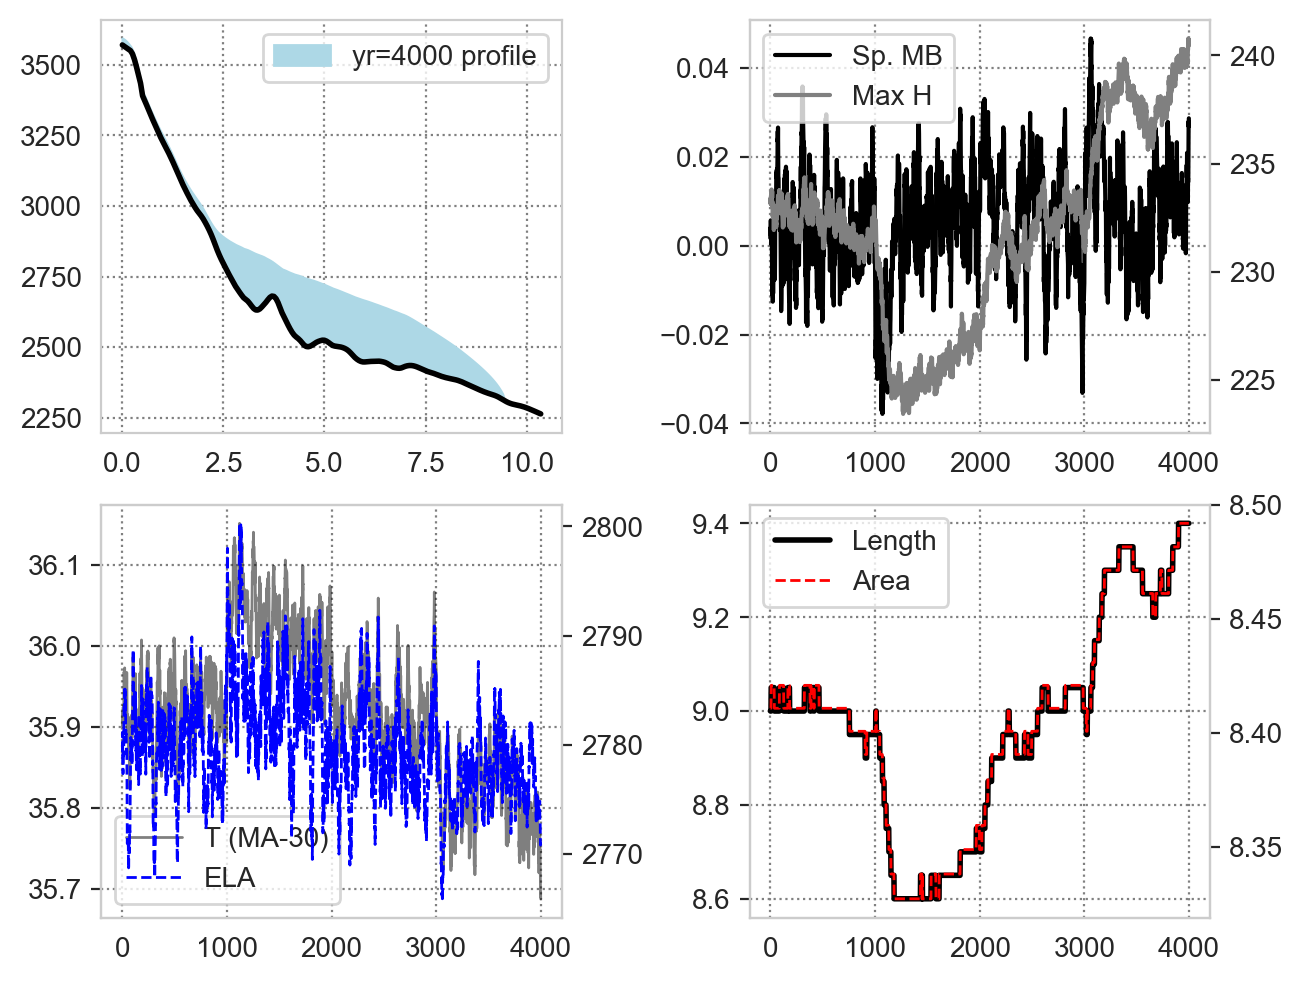

In [236]:
variant = 'off'
fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
no_hmb = model.run(profile=fp, hmb=False, T0=35.92)
no_hmb.plot(smooth=30)

Text(0.5, 0.98, 'Hintereisferner')

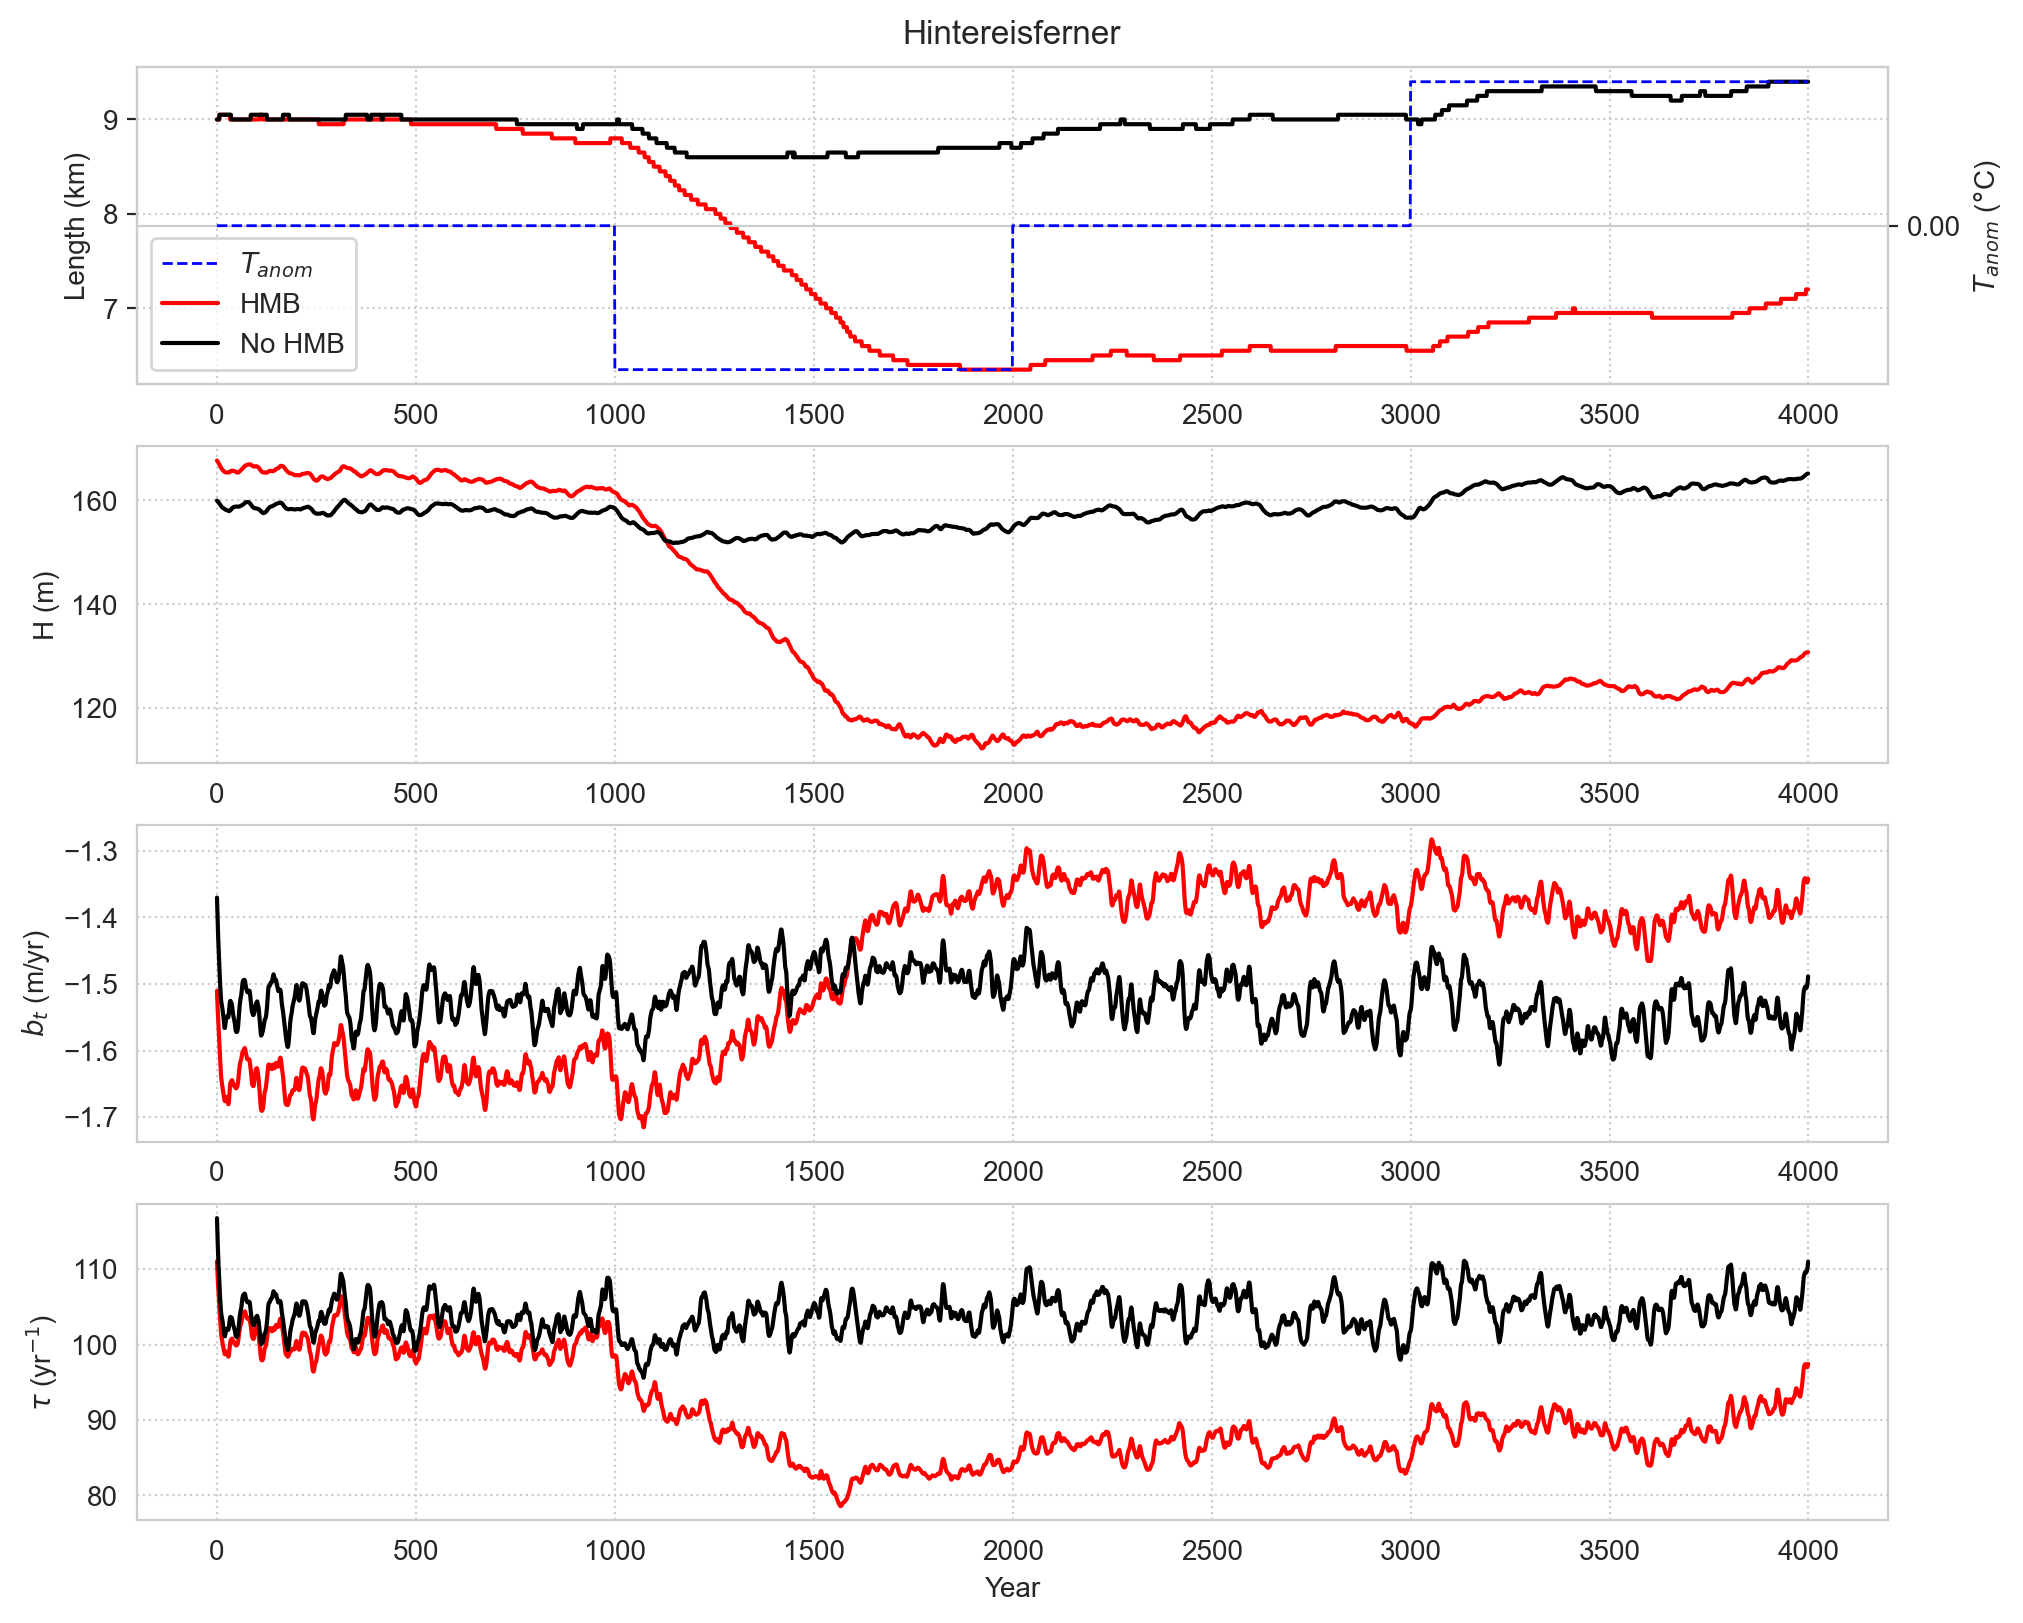

In [237]:

hmb_tau, hmb_H, hmb_bt = gm.calc_tau(hmb)
nhmb_tau, nhmb_H, nhmb_bt = gm.calc_tau(no_hmb)
sos = sci.signal.butter(1, 0.05, output='sos')
hmb_H = sci.signal.sosfiltfilt(sos, hmb_H)
hmb_bt = sci.signal.sosfiltfilt(sos, hmb_bt)
hmb_tau = -hmb_H / hmb_bt
nhmb_H = sci.signal.sosfiltfilt(sos, nhmb_H)
nhmb_bt = sci.signal.sosfiltfilt(sos, nhmb_bt)
nhmb_tau = -nhmb_H / nhmb_bt

fig, ax = plt.subplots(4, 1, figsize=(10, 8), dpi=200, layout='constrained')
ax[0].plot([None], [None], label='$T_{anom}$', c='blue', lw=1, ls='--')
ax[0].plot(hmb.t, hmb.edge / 1000, label='HMB', c='red')
ax[0].plot(no_hmb.t, no_hmb.edge / 1000, label='No HMB', c='black')
ax0b = ax[0].twinx()
ax0b.plot(hmb.t, -temp, label='$T_{anom}$', c='blue', lw=1, ls='--')
ax[1].plot(hmb.t, hmb_H, label='HMB H', c='red')
ax[1].plot(hmb.t, nhmb_H, label='No HMB H', c='black')
ax[2].plot(hmb.t, hmb_bt, label='HMB bt', c='red')
ax[2].plot(hmb.t, nhmb_bt, label='No HMB bt', c='black')
ax[3].plot(hmb.t, hmb_tau, label='HMB tau', c='red')
ax[3].plot(hmb.t, nhmb_tau, label='No HMB tau', c='black')

ax[0].legend()
ax[0].set_ylabel('Length (km)')
ax0b.set_ylabel('$T_{anom}$ ($\degree$C)')
ax0b.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
ax[1].set_ylabel('H (m)')
ax[2].set_ylabel('$b_t$ (m/yr)')
ax[3].set_ylabel(r'$\tau$ (yr$^{-1}$)')
ax[-1].set_xlabel('Year')
for axis in ax:
    axis.grid(which='both', axis='both', ls=':')
    
fig.suptitle('Hintereisferner')

The HMB glacier definitely doesn't respond faster.

# 3. Repeat the test with high mu/low gamma glacier

100%|######################################################| 1000.0/1000.0 [00:03<00:00, 253.87yrs/s


9000.0
hmb feedback = True


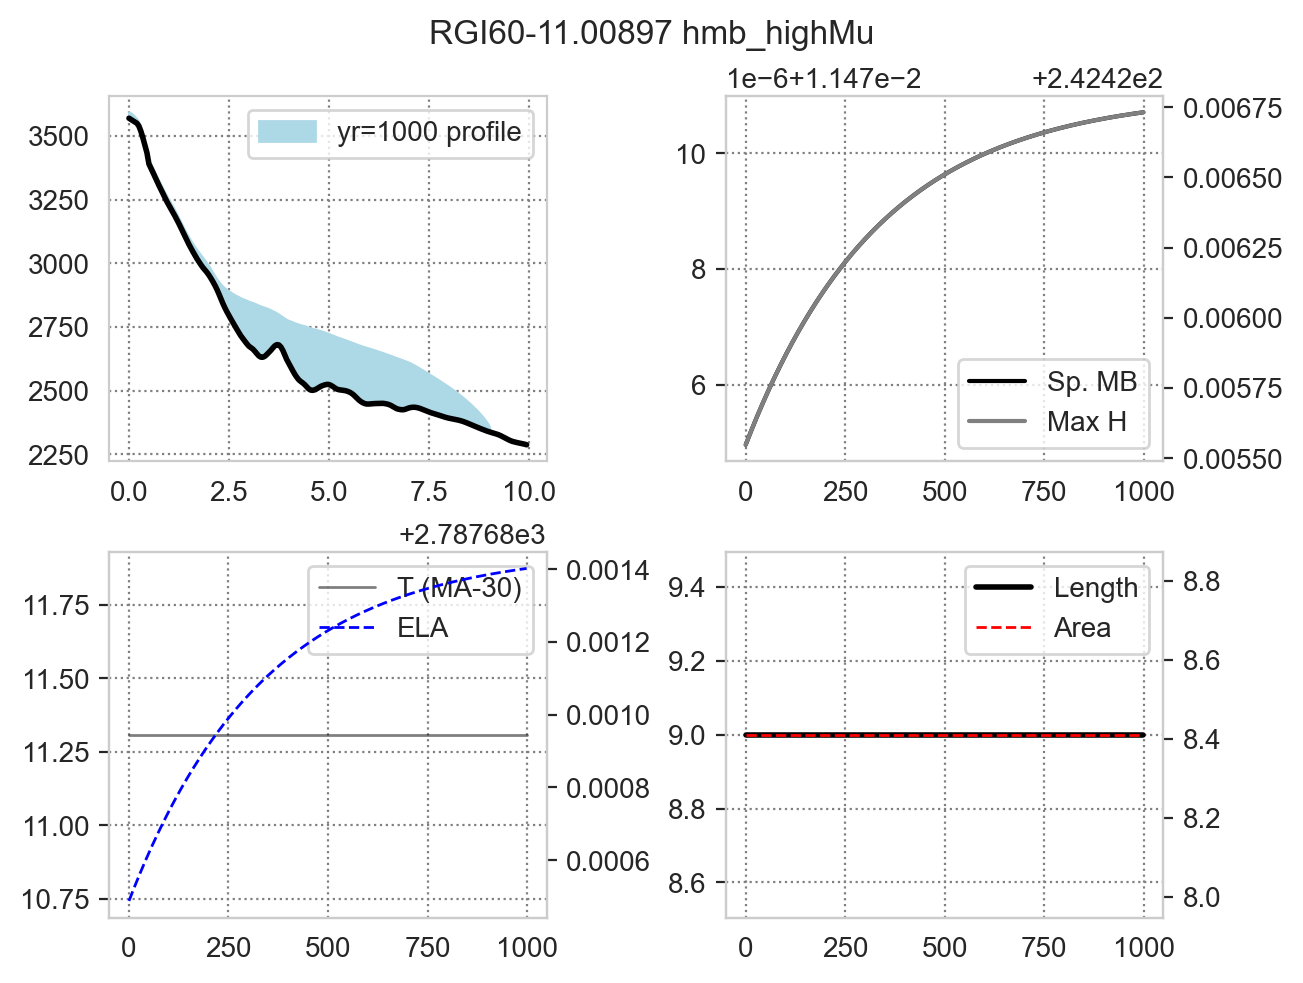

In [21]:
exp_name = 'hmb_highMu'
variant = 'on'
t0 = 0
t1 = 1000
ref0 = 0
ref1 = 100

fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
#fp = Path(ROOT, f'flowline2d_{rgiid}.profile.850.pickle')
model = gm.flowline2d(
    x_gr=geom.x,
    zb_gr=geom.zb,
    x_geom=geom.x,
    w_geom=geom.w,
    profile=fp,
    xmx=geom.x.max(),
    sigT=params['sigT'],
    sigP=params['sigP'],
    delt=0.0125 / 4,
    delx=50,
    ts=t0,
    tf=t1, 
    P0=0.5,
    T0=11.308,
    gamma=4e-3,
    mu=3,  # setting length to 10250
    hmb=True,
)
model.ref_period = (ref0, ref1)
hmb = model.run()

fig, ax = hmb.plot()
fig.suptitle(f'{rgiid} {exp_name}')
fig_output_name = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.png')
fig.savefig(fig_output_name)

if hmb.no_error:
    fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
    hmb.to_pickle(fp)

print(hmb.edge[-1])
print(f"hmb feedback = {hmb.hmb}")

(<Figure size 1600x1600 with 2 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >], dtype=object))

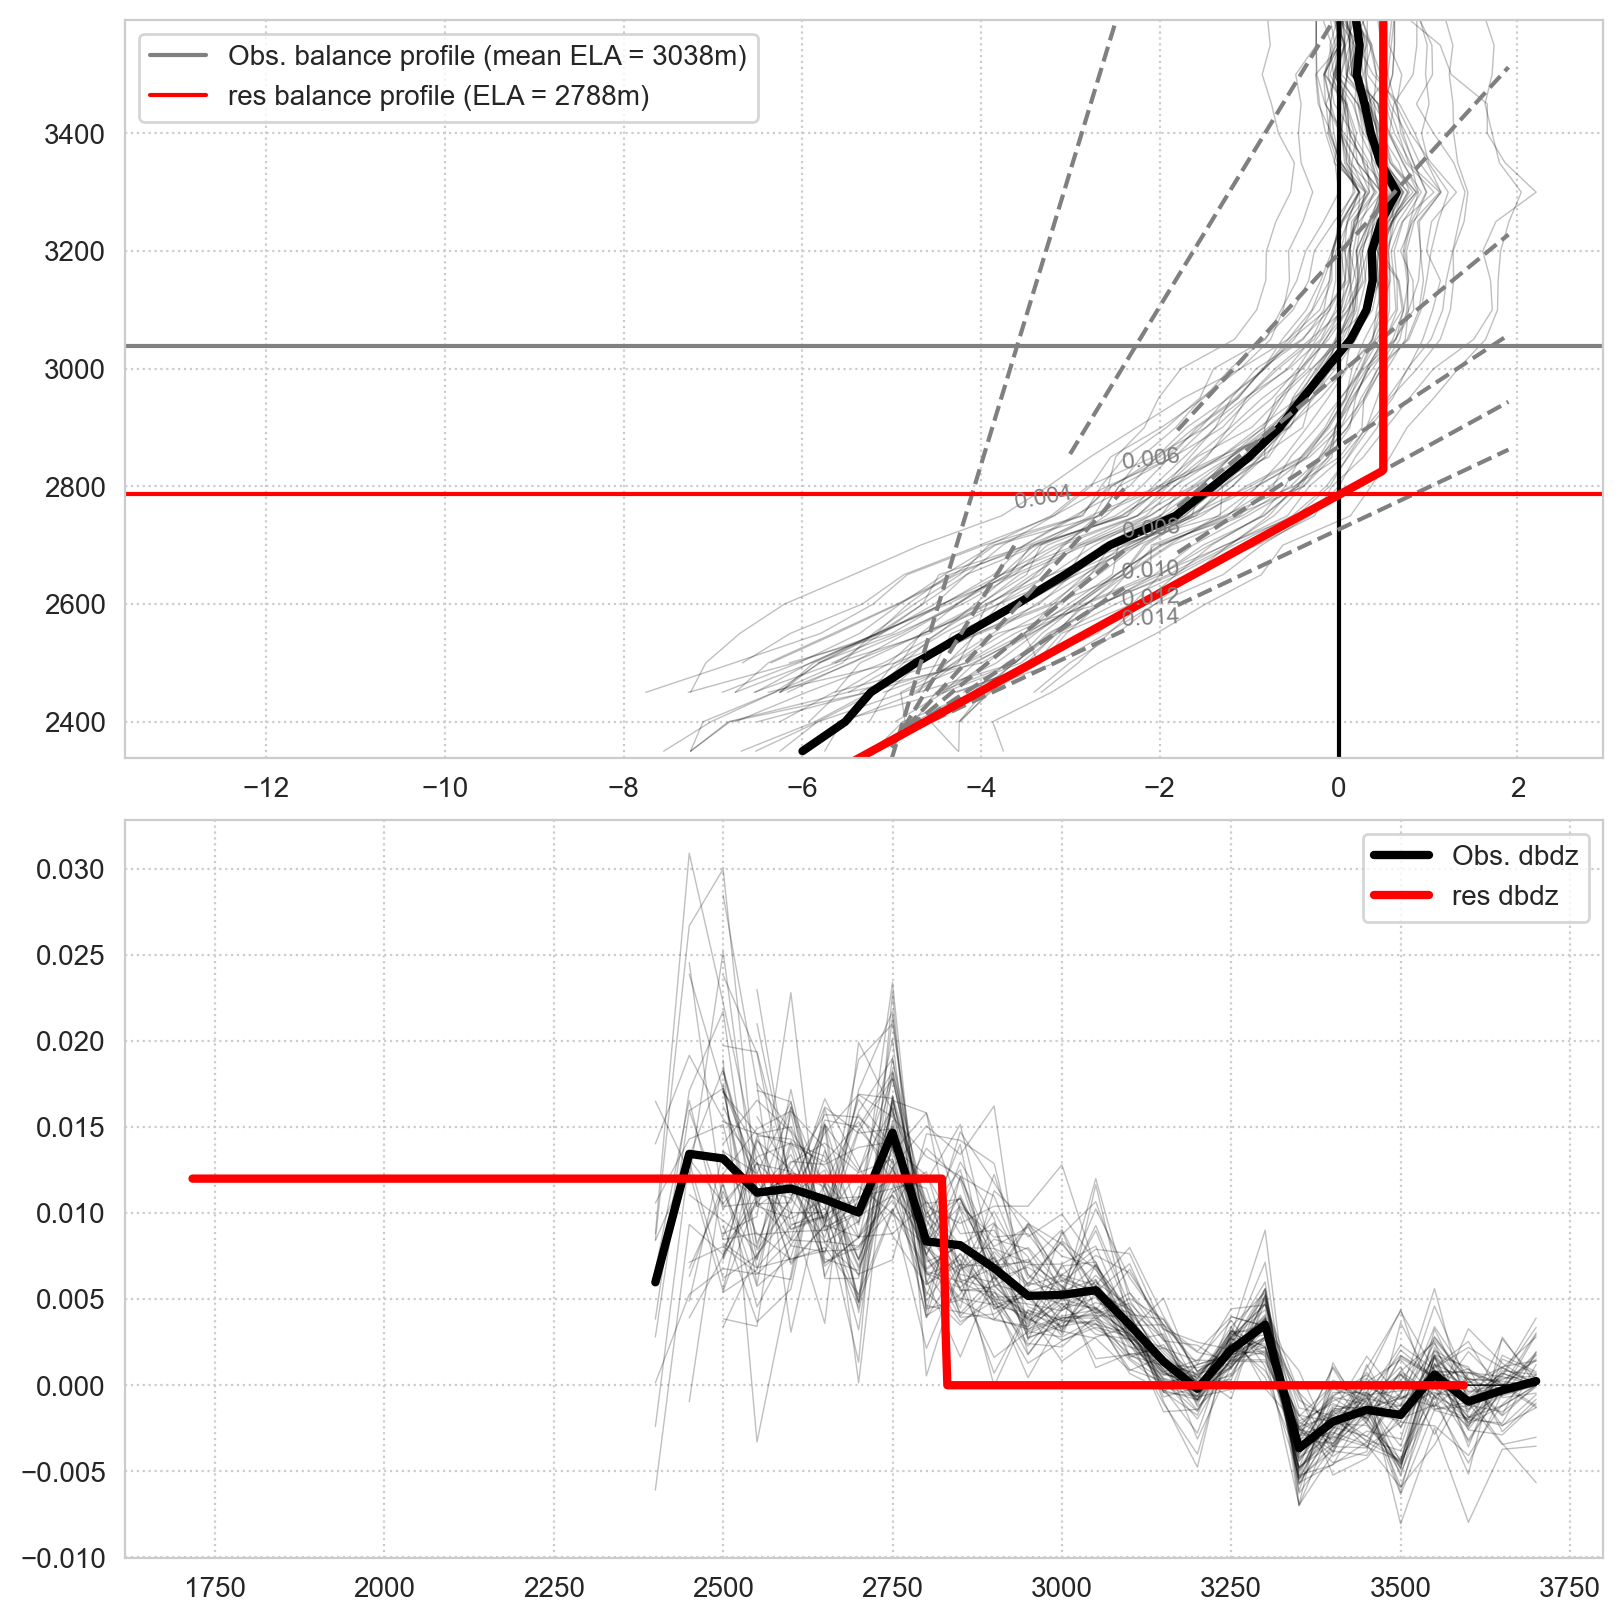

In [25]:
plot_dbdz(hmb, hmb=True)

100%|######################################################| 1000.0/1000.0 [00:03<00:00, 285.60yrs/s


9000.0
no_hmb feedback = False


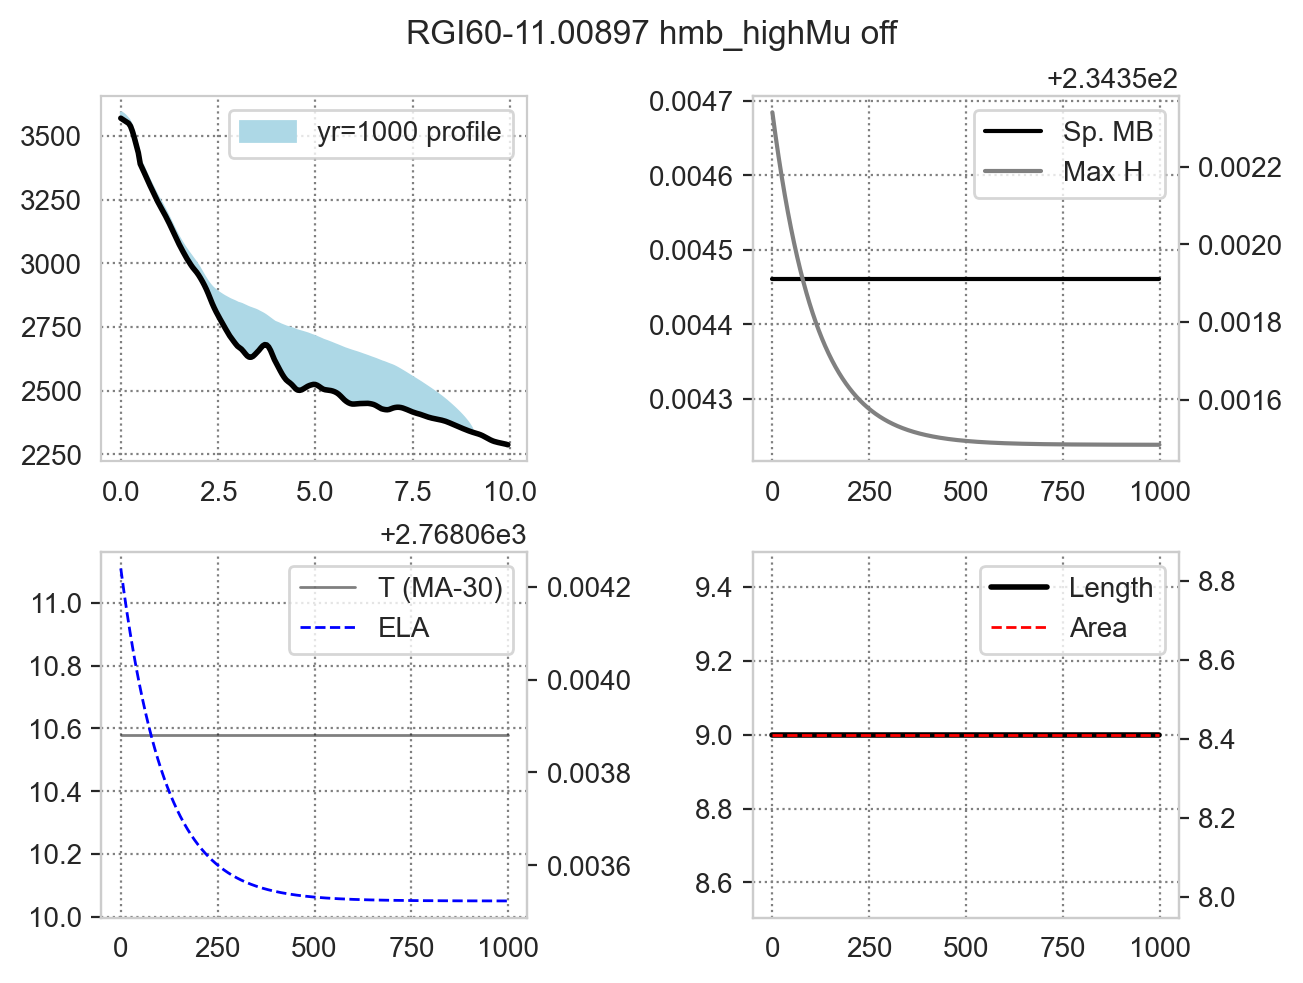

In [27]:
variant = "off"
fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
no_hmb = model.run(hmb=False, T0=10.58, profile=fp)

fig, ax = no_hmb.plot()
fig.suptitle(f'{rgiid} {exp_name} {variant}')
fig_output_name = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.png')
fig.savefig(fig_output_name)

if no_hmb.no_error:
    fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.9km.pickle')
    no_hmb.to_pickle(fp)

print(no_hmb.edge[-1])
print(f"no_hmb feedback = {no_hmb.hmb}")

(<Figure size 1600x1600 with 2 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >], dtype=object))

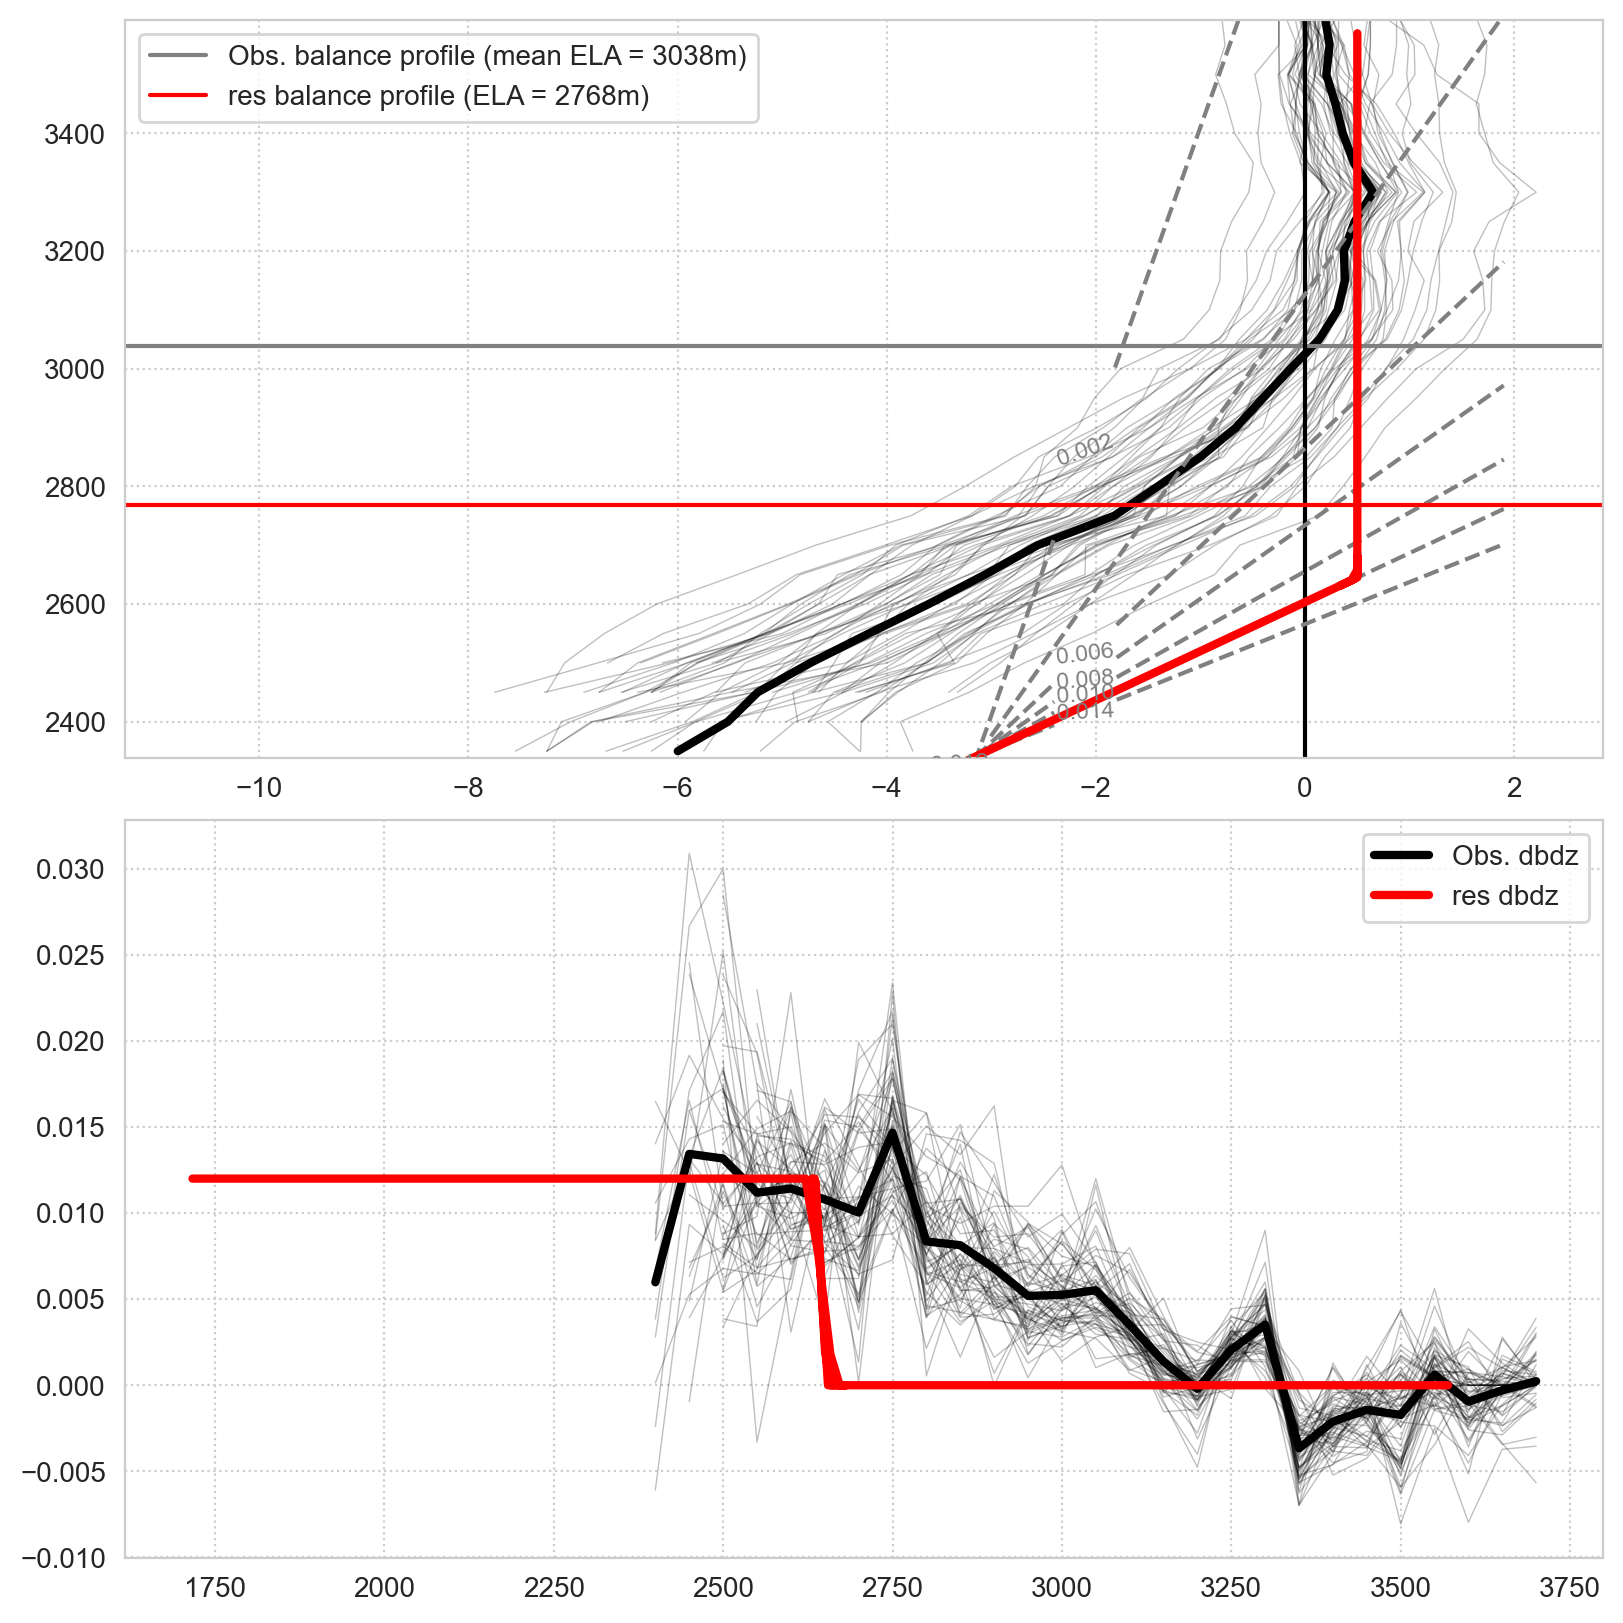

In [28]:
plot_dbdz(no_hmb, hmb=False)

In [29]:
no_hmb.b[-1, no_hmb.edge_idx[-1]]  # bt

-3.1702924829947126

# 4. Can we get the modeled bt to match observed with HMB turned off?
A couple glaciers with different settings to try and make bt more negative

100%|########################################################| 500.0/500.0 [00:02<00:00, 237.70yrs/s


9050.0
hmb feedback = False


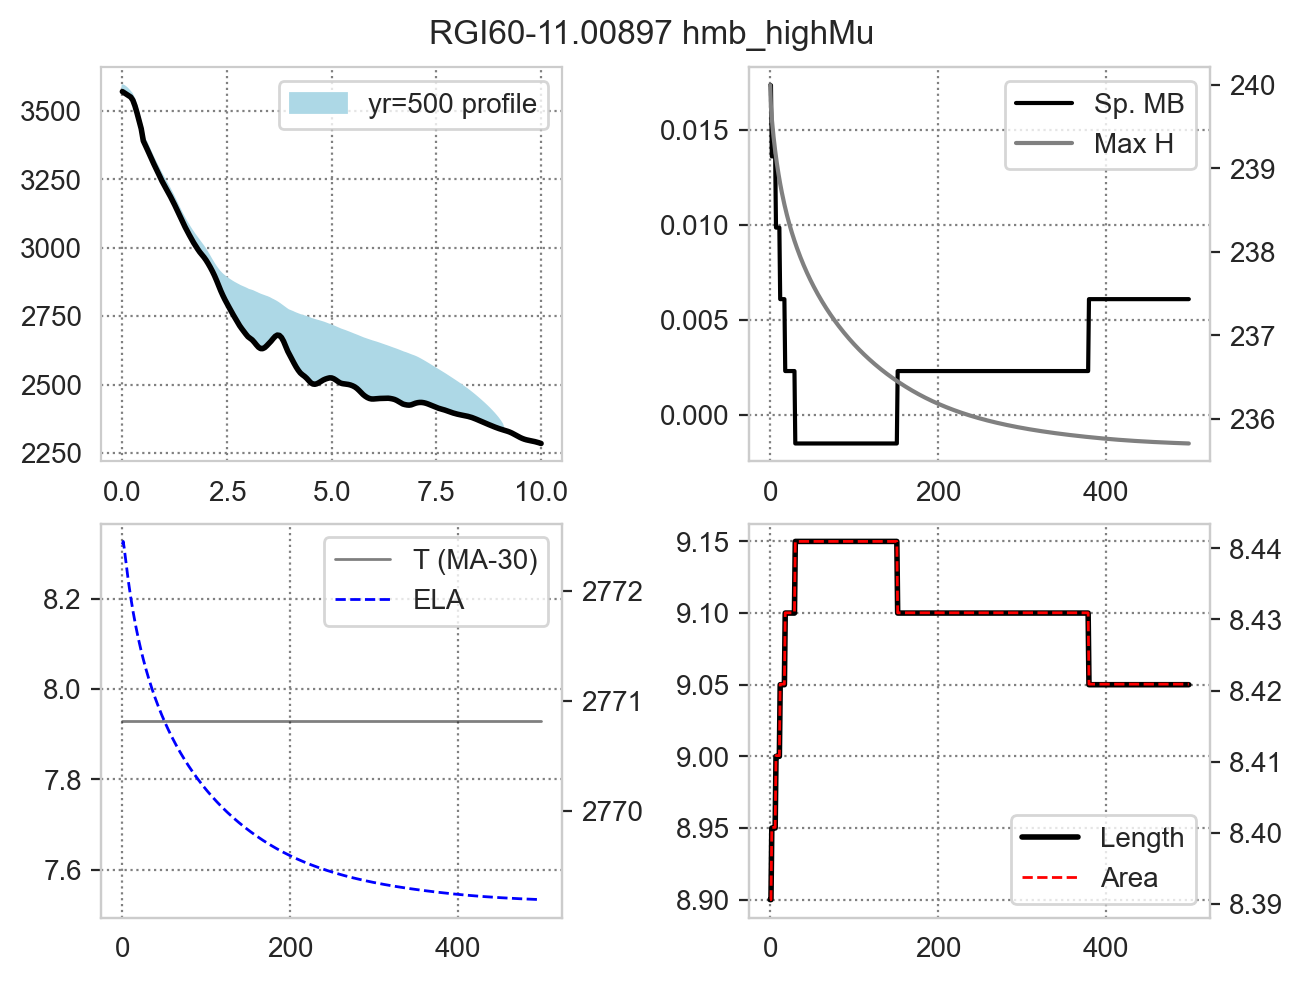

In [35]:
exp_name = 'hmb_highMu'
variant = 'off'
t0 = 0
t1 = 500
ref0 = 0
ref1 = 100

#fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.pickle')
fp = Path(ROOT, f'flowline2d_{rgiid}.profile.850.pickle')
model = gm.flowline2d(
    x_gr=geom.x,
    zb_gr=geom.zb,
    x_geom=geom.x,
    w_geom=geom.w,
    profile=fp,
    xmx=geom.x.max(),
    sigT=params['sigT'],
    sigP=params['sigP'],
    delt=0.0125 / 4,
    delx=50,
    ts=t0,
    tf=t1, 
    P0=0.5,
    T0=7.93,
    gamma=3e-3,
    mu=4,  # setting length to 10250
    hmb=False,
)
model.ref_period = (ref0, ref1)
no_hmb = model.run()

fig, ax = no_hmb.plot()
fig.suptitle(f'{rgiid} {exp_name}')

print(no_hmb.edge[-1])
print(f"hmb feedback = {no_hmb.hmb}")

(<Figure size 1600x1600 with 2 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >], dtype=object))

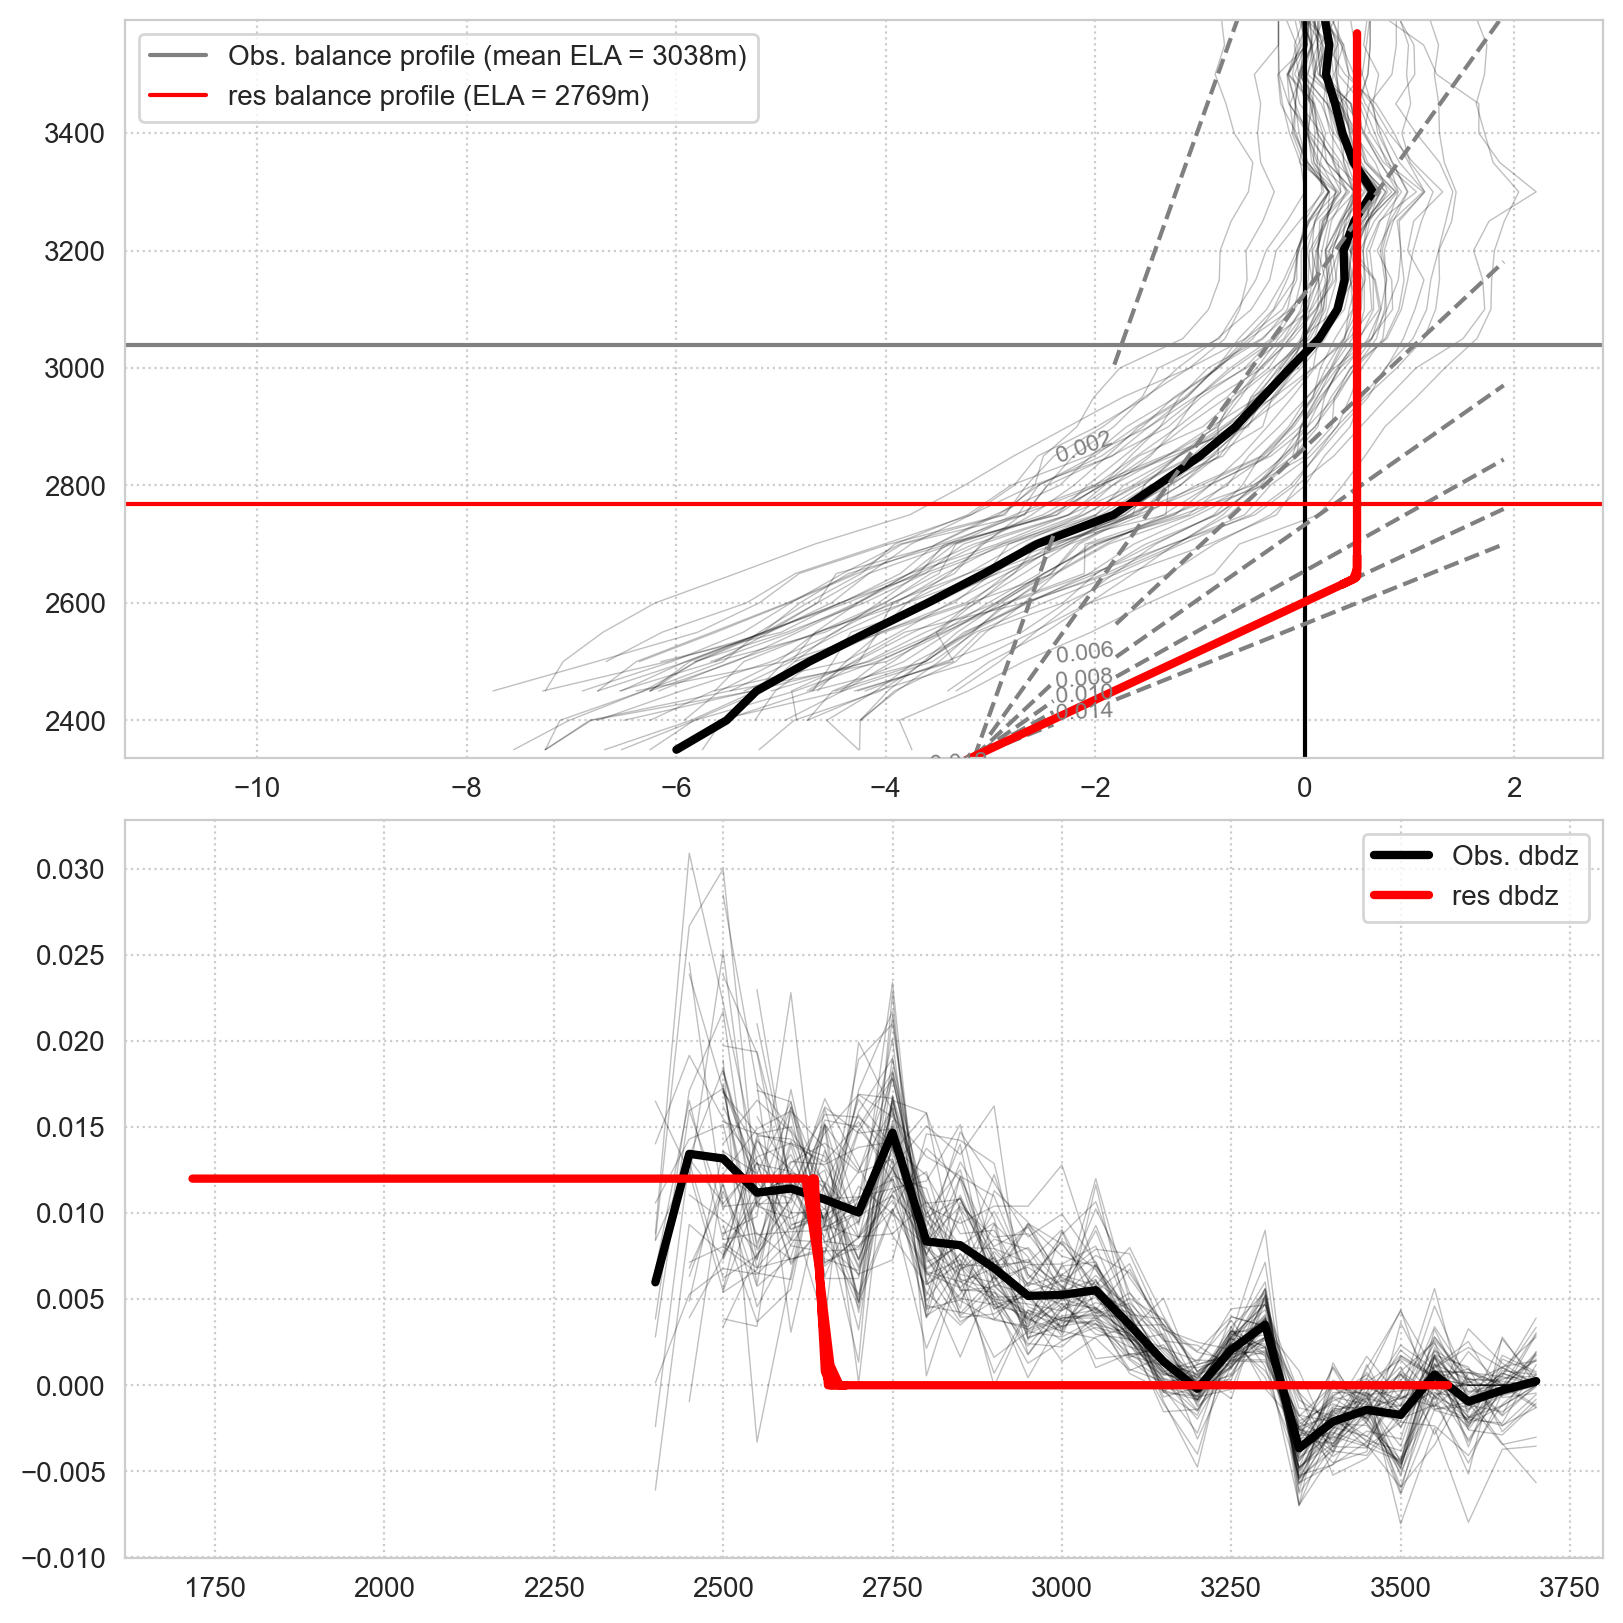

In [36]:
plot_dbdz(no_hmb, hmb=False)

100%|########################################################| 500.0/500.0 [00:02<00:00, 225.91yrs/s


8950.0
hmb feedback = False


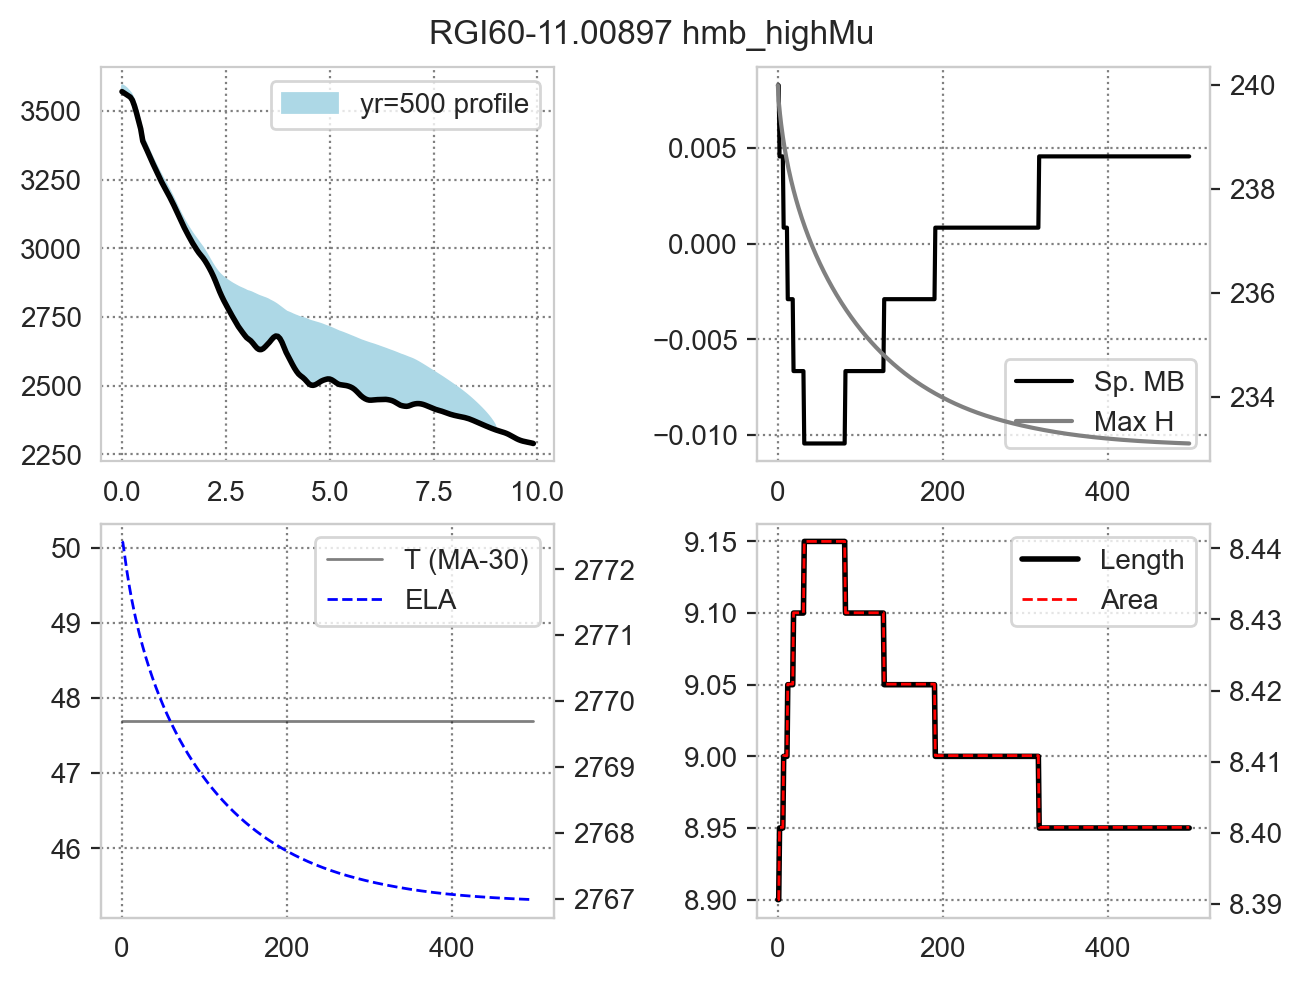

In [39]:
exp_name = 'hmb_highMu'
variant = 'off'
t0 = 0
t1 = 500
ref0 = 0
ref1 = 100

#fp = Path(f'flowline2d_{rgiid}.{exp_name}.{variant}.pickle')
fp = Path(ROOT, f'flowline2d_{rgiid}.profile.850.pickle')
model = gm.flowline2d(
    x_gr=geom.x,
    zb_gr=geom.zb,
    x_geom=geom.x,
    w_geom=geom.w,
    profile=fp,
    xmx=geom.x.max(),
    sigT=params['sigT'],
    sigP=params['sigP'],
    delt=0.0125 / 4,
    delx=50,
    ts=t0,
    tf=t1, 
    P0=0.5,
    T0=47.7,
    gamma=18e-3,
    mu=0.65, 
    hmb=False,
)
model.ref_period = (ref0, ref1)
no_hmb = model.run()

fig, ax = no_hmb.plot()
fig.suptitle(f'{rgiid} {exp_name}')

print(no_hmb.edge[-1])
print(f"hmb feedback = {no_hmb.hmb}")

(<Figure size 1600x1600 with 2 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >], dtype=object))

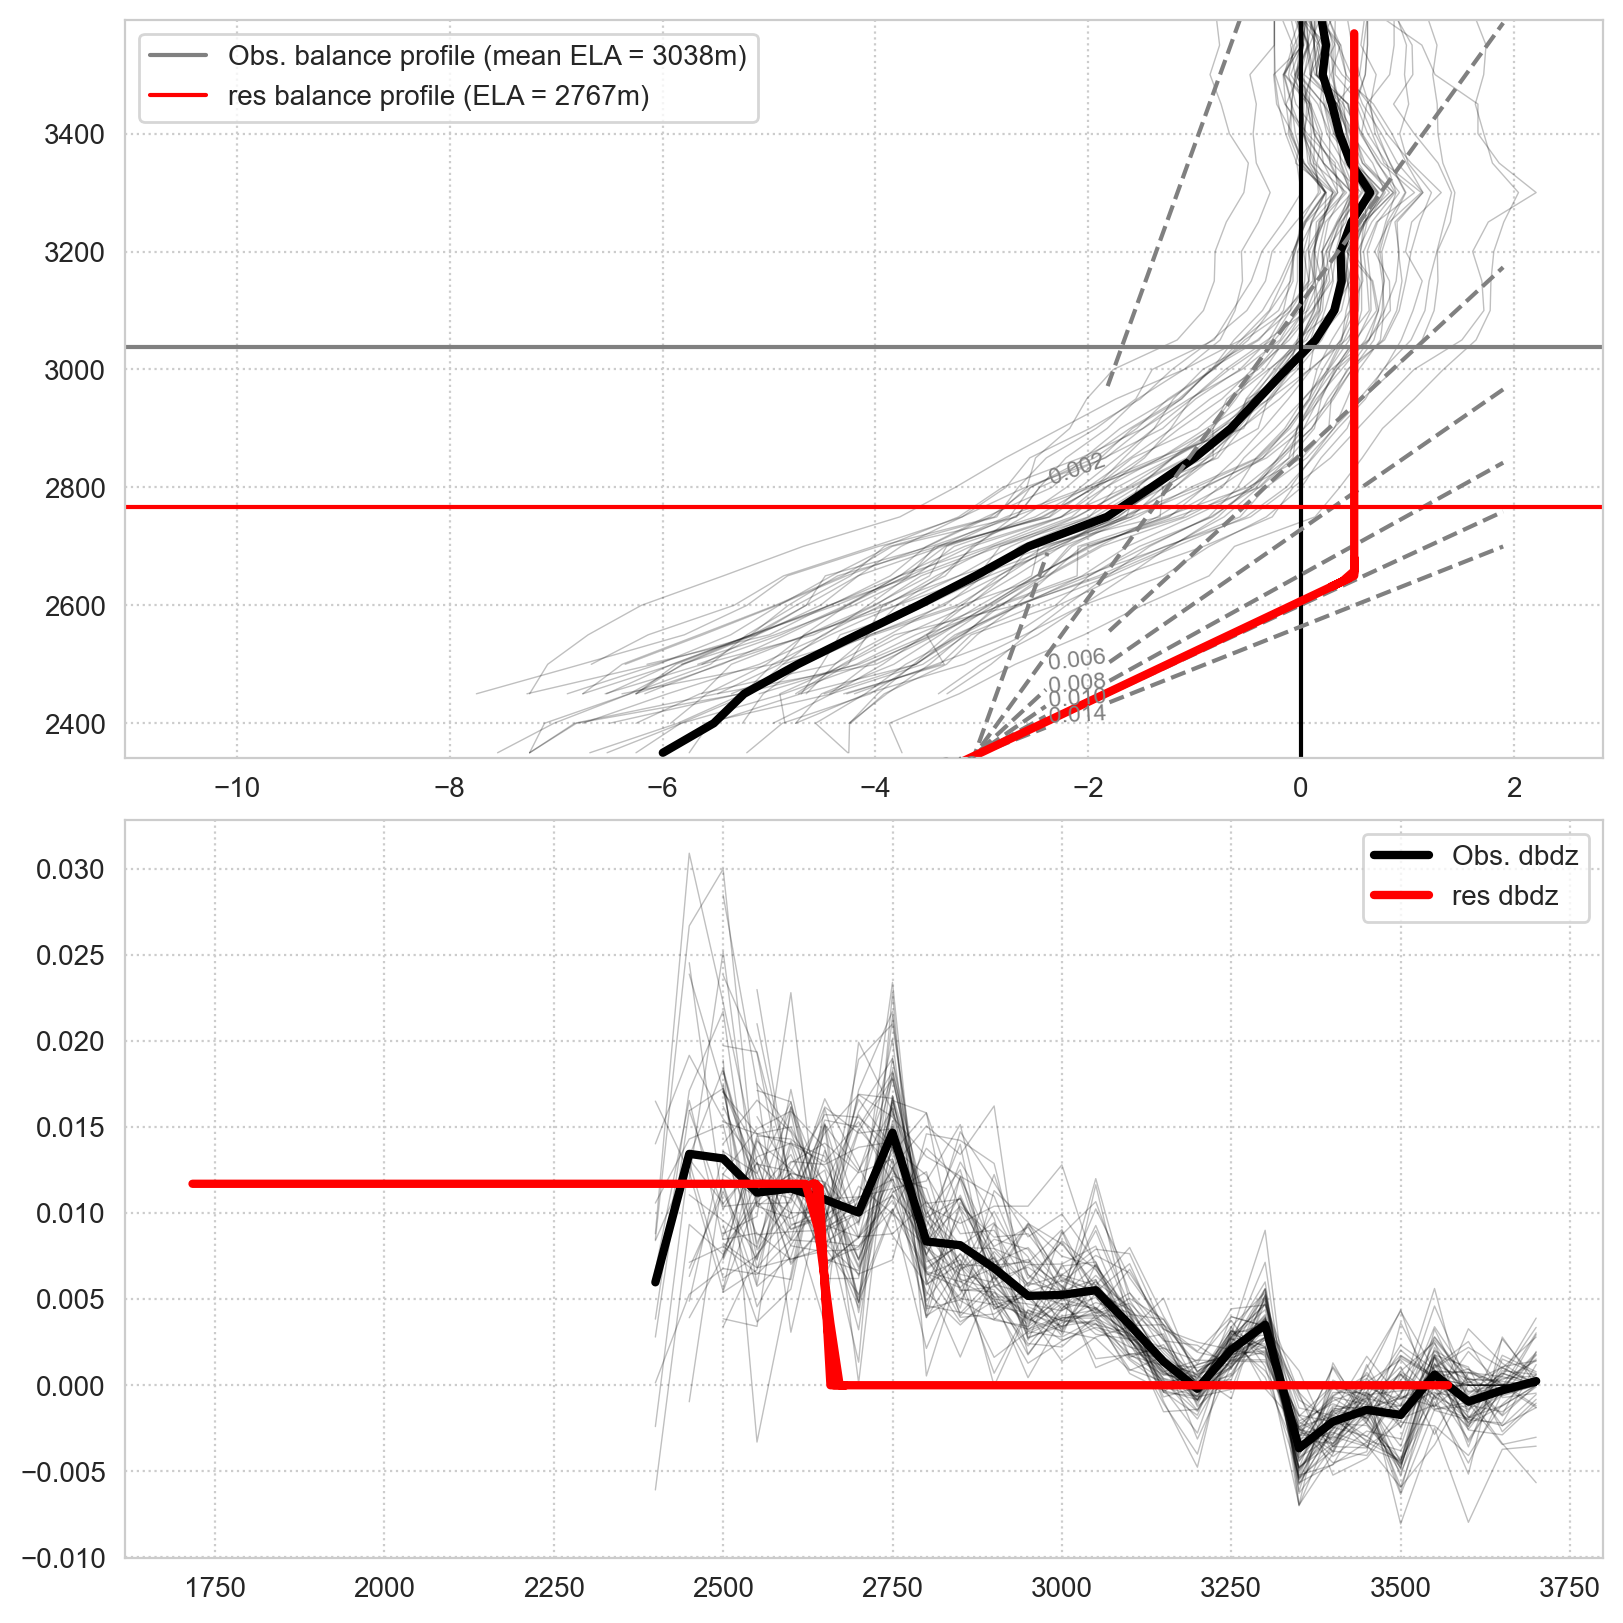

In [40]:
plot_dbdz(no_hmb, hmb=False)